## imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

data_folder = Path( os.environ["DATA_FOLDER"] )
L_folder  = data_folder / "L"
ab_folder = data_folder / "ab"
tags_path = data_folder / "tags.npy"
wti_path  = data_folder / "words_to_inds.npy"

In [2]:
## for tags
from collections import OrderedDict

## tags research

### word tokenization

In [5]:
tags = np.load(tags_path)
counts  = np.load(wti_path, allow_pickle='TRUE').item()

vocab_size = len(counts)

In [6]:
## all 0s. will have counts
for k in counts.keys():
    counts[k] = 0

In [7]:
tag_num = 8

for k in counts.keys():
    counts[k] = 0

for row in tqdm(tags, colour="#cccc50"):
    # rows = (10_000,)
    for example in row:
        # example = 1 np string of tags

        split_words = example.strip().split(' ')
        # count <pad> token, which is not yet present
        counts[''] += max(tag_num - len(split_words), 0)


        for word in split_words:
            if word != '':
                counts[word] += 1
    

counts['']

100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


1616305

In [8]:
counts_ord = OrderedDict(
    sorted(counts.items(), key=lambda x: x[1], reverse=True)
)

In [17]:
len(counts_ord), vocab_size

(761279, 761279)

In [29]:
for i, (k, v) in enumerate(counts_ord.items()):
    k = '`' + k + '`'
    print(f"{k:12s}: {v:9,d}")

    if i >= 20:
        break

``          : 1,616,305
`nikon`     :    45,952
`canon`     :    43,308
`nature`    :    40,284
`2008`      :    39,955
`sky`       :    33,332
`blue`      :    31,931
`macro`     :    30,520
`bw`        :    30,290
`flower`    :    29,564
`water`     :    28,683
`red`       :    26,407
`portrait`  :    26,240
`green`     :    24,880
`art`       :    23,135
`hdr`       :    22,390
`california`:    22,277
`light`     :    22,175
`night`     :    22,162
`sunset`    :    21,667
`white`     :    21,415


#### graphs

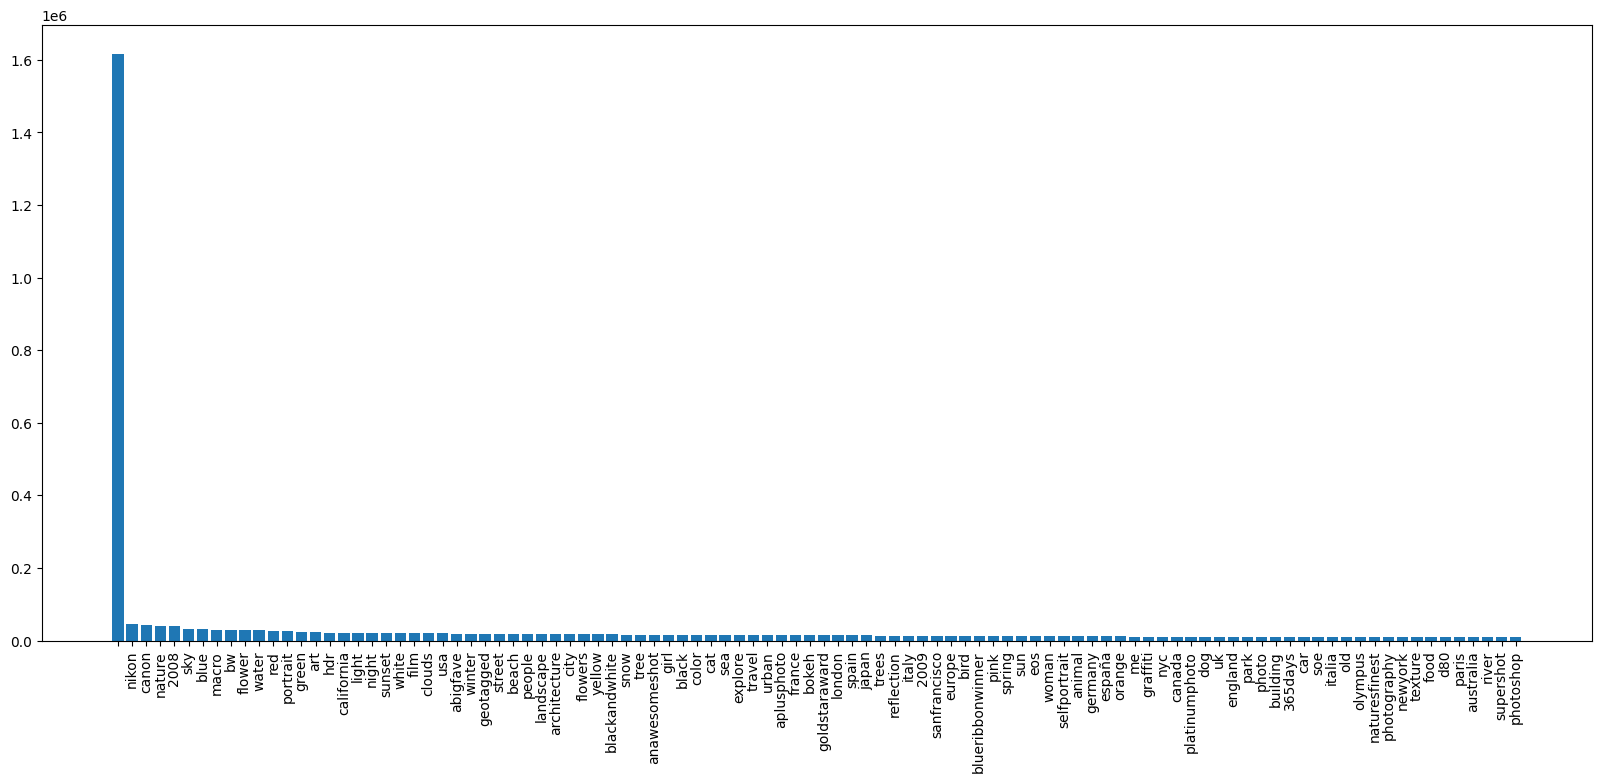

In [39]:
most_common = 100

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_ord.items() )
labels = np.array(labels[:most_common])
values = np.array(values[:most_common])

plt.bar(labels, values)
plt.xticks(rotation='vertical')
plt.show()

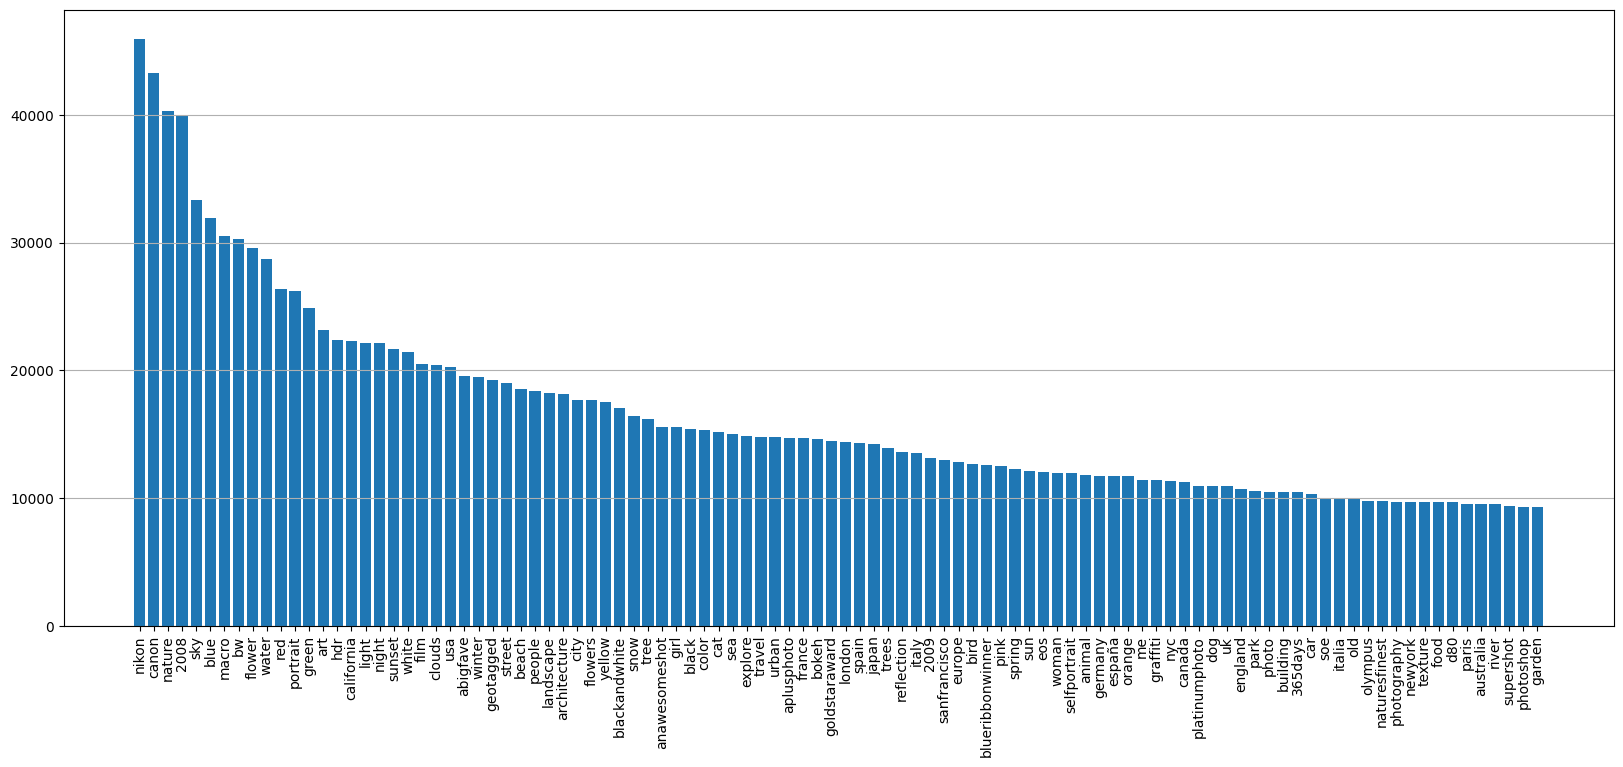

In [41]:
most_common = 100

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_ord.items() )
labels = np.array(labels[1:most_common+1])
values = np.array(values[1:most_common+1])

plt.bar(labels, values)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.show()

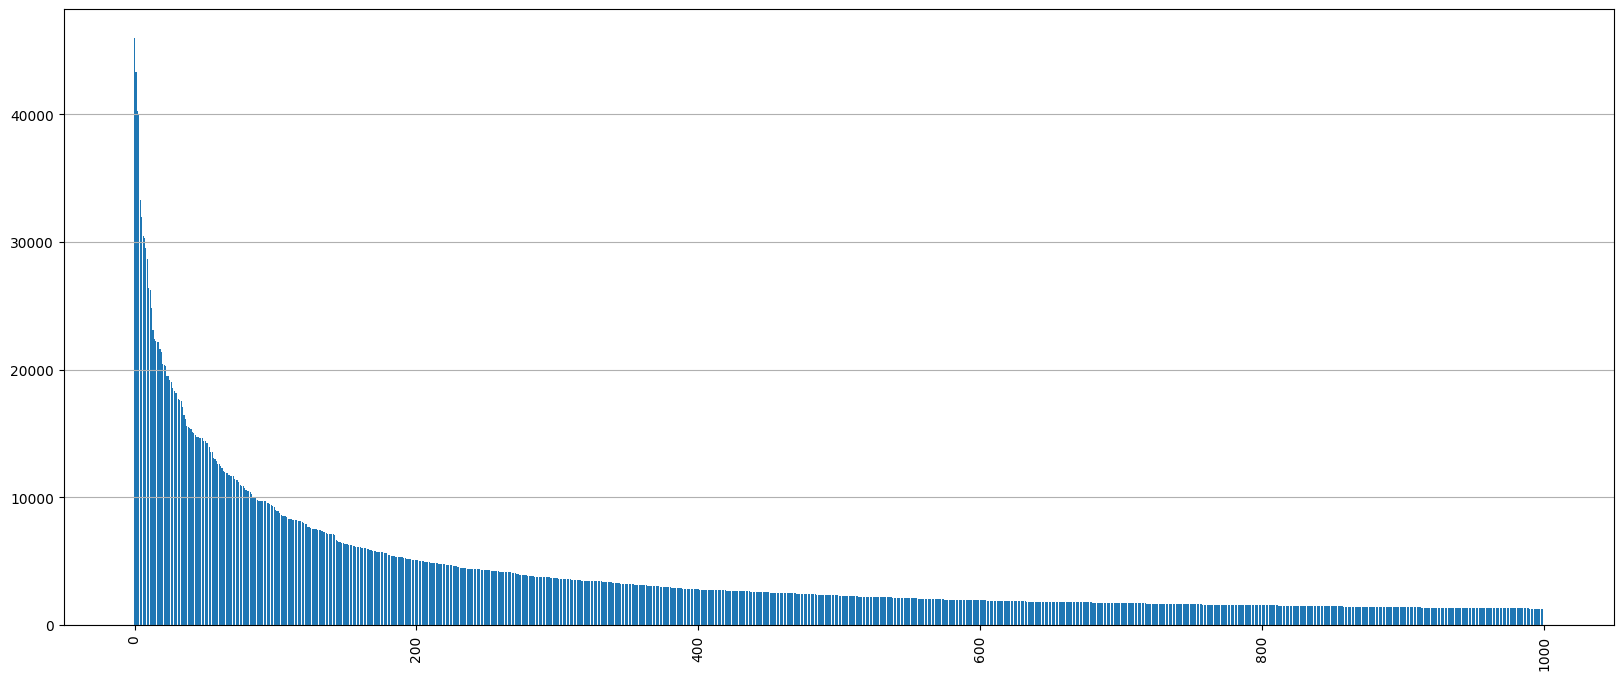

In [45]:
most_common = 1000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_ord.items() )
# labels = np.array(labels[1:most_common+1])
values = np.array(values[1:most_common+1])

plt.bar(range(most_common), values)
plt.xticks(labels=None, rotation='vertical')
plt.grid(axis='y')
plt.show()

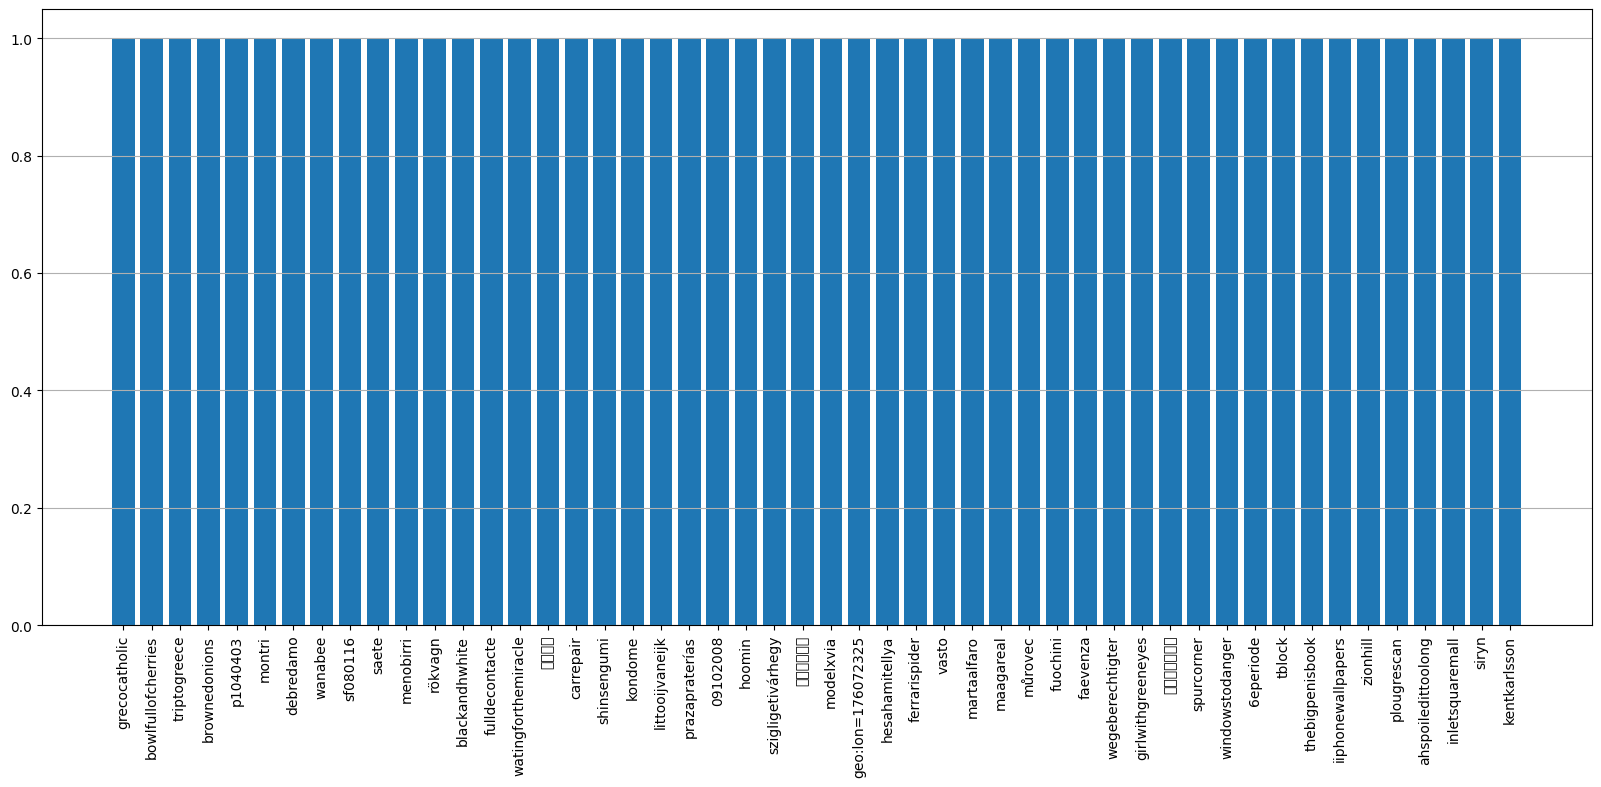

In [88]:
least_common = 50

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_ord.items() )
labels = np.array(labels[-least_common:])
values = np.array(values[-least_common:])

plt.bar(labels, values)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.show()

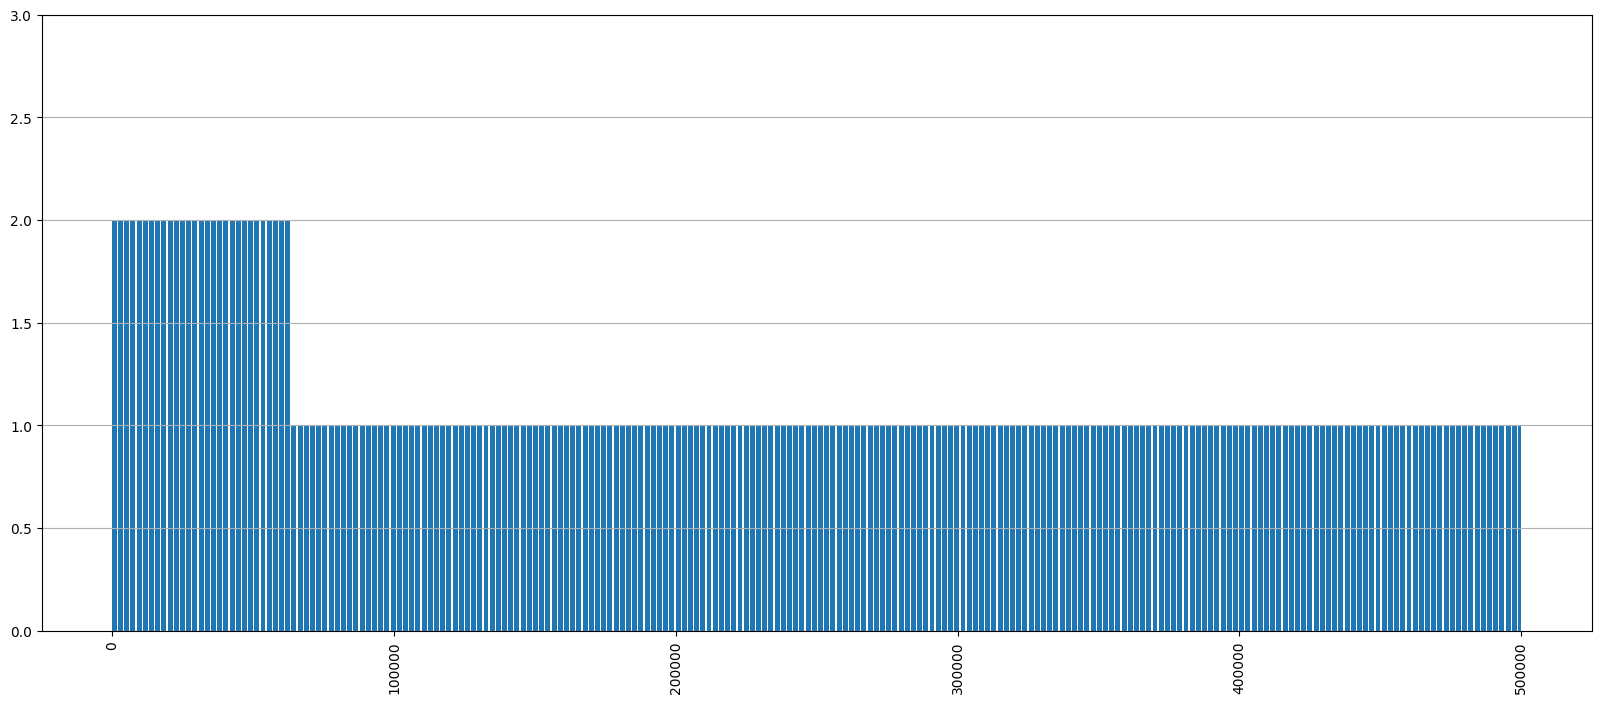

In [91]:
least_common = 500_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_ord.items() )
# labels = np.array(labels[-least_common:])
values = np.array(values[-least_common:])

plt.bar(range(least_common), values)
plt.xticks(labels=None, rotation='vertical')
plt.grid(axis='y')
plt.ylim(top=3)
plt.show()

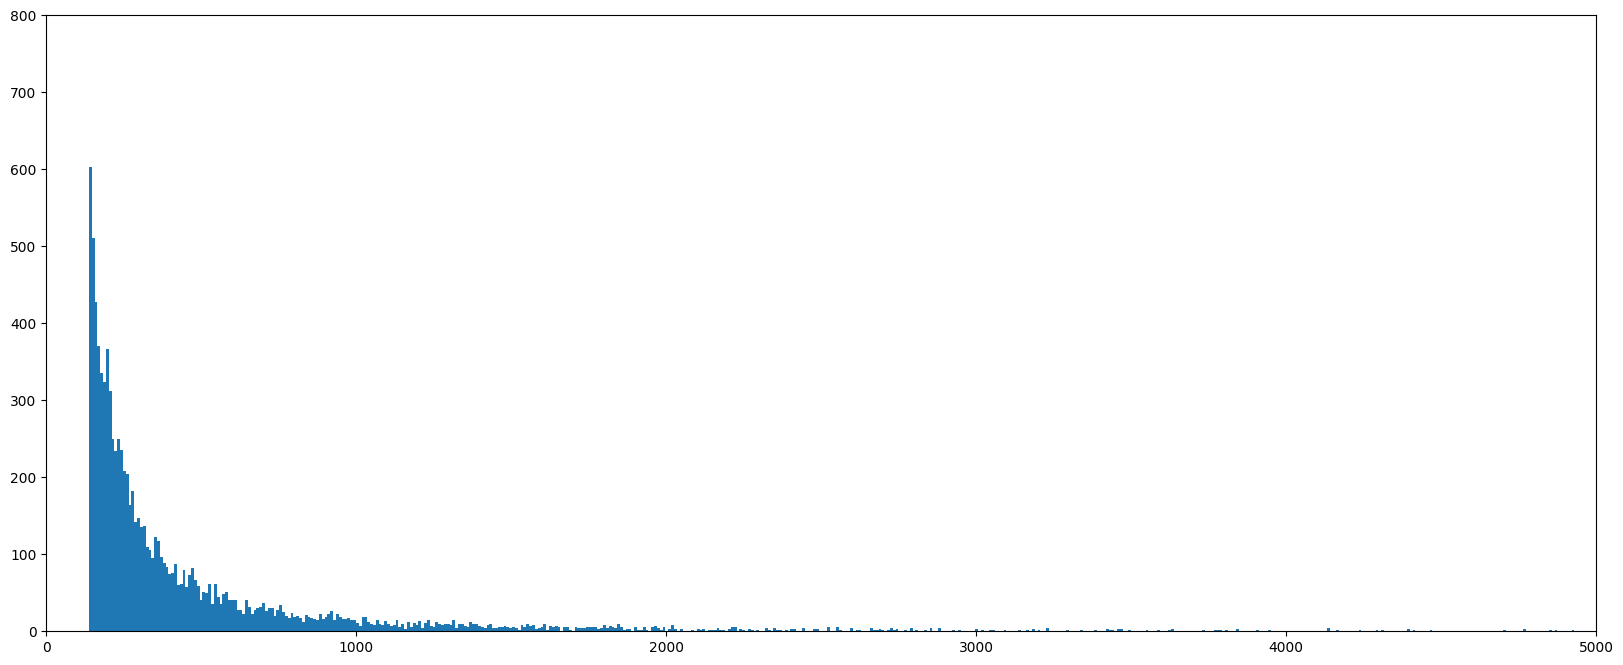

In [77]:
most_common = 10_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_ord.items() )

values = np.array(values[1:most_common])
# np.histogram(values, bins=1_000)

plt.hist(values, bins=5000)
plt.ylim(top=800)
plt.xlim(left=0, right=5_000)
plt.show()

In [97]:
counts["bw"], counts.get("blackwhite", 0), counts.get("bnw", 0), counts.get("gray", 0)

(30290, 6157, 89, 1364)

In [23]:
_, values = zip( *counts_ord.items() )
values = np.array( values )

print( f"n(``) = {values[0].item():,d}" )
print( f"n(!``) = {values[1:].sum().item():,d}" )
print( f"n(!``) = {values[1:200_000].sum().item():,d}" )

n(``) = 1,616,305
n(!``) = 11,045,455
n(!``) = 10,336,244


### tiktoken

In [3]:
import tiktoken

o200k_base = tiktoken.get_encoding("o200k_base",)

encoding = tiktoken.Encoding(
    name="o200k_base",
    pat_str=o200k_base._pat_str,
    mergeable_ranks=o200k_base._mergeable_ranks,
    special_tokens={
        # **o200k_base._special_tokens,
        "<|endoftext|>": 199998,
        "<|pad|>": 199999
    },
)
spec_toks = encoding.special_tokens_set
# spec_toks = encoding._special_tokens

tags = np.load(tags_path)

In [4]:
print( len(encoding._mergeable_ranks) )
encoding._mergeable_ranks[" ".encode("utf-8")]

199998


220

In [5]:
print( encoding.encode(""), encoding.encode(" "), encoding.encode("\n") )
print( encoding.encode("qwerty, ytrewq <|pad|>", allowed_special="all") )
print( encoding.encode("qwerty, ytrewq <|pad|>", allowed_special=spec_toks) )

[] [220] [198]
[80, 21773, 88, 11, 342, 4086, 86, 80, 220, 199999]
[80, 21773, 88, 11, 342, 4086, 86, 80, 220, 199999]


#### all tokens raw

In [6]:
counts = np.zeros(encoding.n_vocab, dtype=np.uint32)


for row in tqdm(tags, colour="#cccc50"):
    # rows = (10_000,)
    for example in row:
        # example = 1 np string of tags

        tokens = encoding.encode(example)

        for token in tokens:
            counts[token] += 1
    
    
counts[-1]

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


np.uint32(0)

In [7]:
print( 
    f"expectence  = {int(23.5*100*10_000):,d}",
    f"actuall sum = {counts.sum():,d}",
    f"="*30,
    f"in percents = {counts.sum() / (23.5*10_000):,.4f}%",
    sep="\n"
)

expectence  = 23,500,000
actuall sum = 23,581,760
in percents = 100.3479%


In [8]:
for token in spec_toks:
    print(token.encode("utf-8"))

b'<|endoftext|>'
b'<|pad|>'


In [9]:
encoding._special_tokens

{'<|endoftext|>': 199998, '<|pad|>': 199999}

In [9]:
counts_dict = {}

for token, index  in encoding._mergeable_ranks.items():
    counts_dict[token] = counts[index].item()

for st, i in encoding._special_tokens.items():
    counts_dict[st.encode("utf-8")] = counts[i].item()


In [10]:
counts_dict_ord = OrderedDict(
    sorted(counts_dict.items(), key=lambda x: x[1], reverse=True)
)

In [11]:
len(counts_dict_ord), len(counts_dict), encoding.n_vocab

(200000, 200000, 200000)

In [12]:
for i, (k, v) in enumerate(counts_dict_ord.items()):
    k = '`' + k.decode("utf-8") + '`'
    print(f"{k:12s}: {v:9,d}")

    if i >= 20:
        break

` `         : 1,262,910
`200`       :   121,541
`f`         :   113,400
`d`         :   103,774
`on`        :    82,238
`mm`        :    78,879
`8`         :    78,212
` d`        :    70,947
` nik`      :    61,551
`y`         :    60,577
`c`         :    57,774
` canon`    :    56,107
`ot`        :    55,509
`r`         :    52,635
`s`         :    49,452
`b`         :    45,494
` nature`   :    44,788
`ia`        :    44,623
` black`    :    43,472
` b`        :    43,359
` f`        :    42,468


In [13]:
key_list = list(counts_dict_ord.keys())
start = 72_400
end = 72_500
step = (end - start) // 4

print(
    key_list[start : start + step],
    key_list[start + step : start + 2*step],
    key_list[start + 2*step : start + 3*step],
    key_list[start + 3*step : end],
    sep='\n'
)

[b'vura', b' diverted', b'ospels', b'continuous', b' \xe0\xa4\xb8\xe0\xa5\x82\xe0\xa4\xb0\xe0\xa5\x8d\xe0\xa4\xaf', b'roepen', b'hebb', b' anim\xc3\xa9', b' iib', b' bester', b' h\xe1\xba\xadu', b'\xe5\x91\xbb\xe5\x90\x9f', b' diminution', b' pr\xc3\xa9l', b' apareci\xc3\xb3', b'ljive', b'\xe0\xa4\xb2\xe0\xa5\x8b\xe0\xa4\x95', b' adulta', b' feina', b' \xd8\xb3\xd9\x83', b'owatt', b' concili', b'sels', b' encontre', b' dedica\xc3\xa7\xc3\xa3o']
[b'holde', b' electricians', b' hassles', b'encha', b' deportivos', b' mnemonic', b'notif', b' \xd1\x87\xd0\xb5\xd0\xbb', b' saav', b'werfen', b'!', b'"', b'#', b'$', b'%', b'&', b"'", b'(', b')', b'*', b'+', b',', b'-', b'.', b'/']
[b';', b'<', b'>', b'?', b'@', b'A', b'B', b'C', b'D', b'E', b'F', b'H', b'I', b'J', b'K', b'L', b'M', b'O', b'P', b'Q', b'R', b'S', b'T', b'U', b'X']
[b'Y', b'Z', b'[', b'\\', b']', b'^', b'_', b'`', b'\xc0', b'\xc1', b'\xc2', b'\xc3', b'\xc6', b'\xc8', b'\xce', b'\xcf', b'\xd0', b'\xd1', b'\xd3', b'\xd4', b'\xd5', 

##### graphs

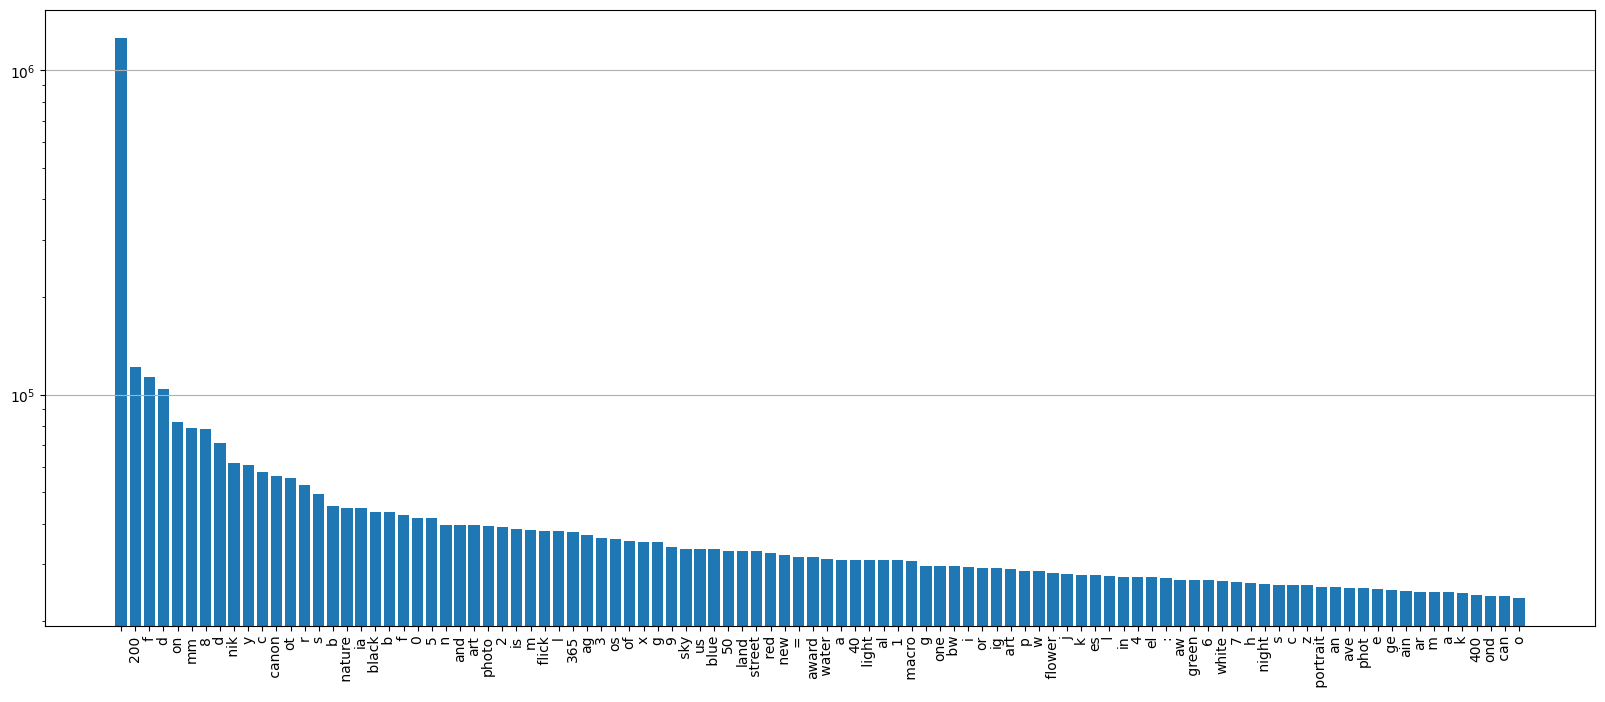

In [14]:
most_common = 100

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
labels = np.array(labels[:most_common])
values = np.array(values[:most_common])


plt.bar(labels, values)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

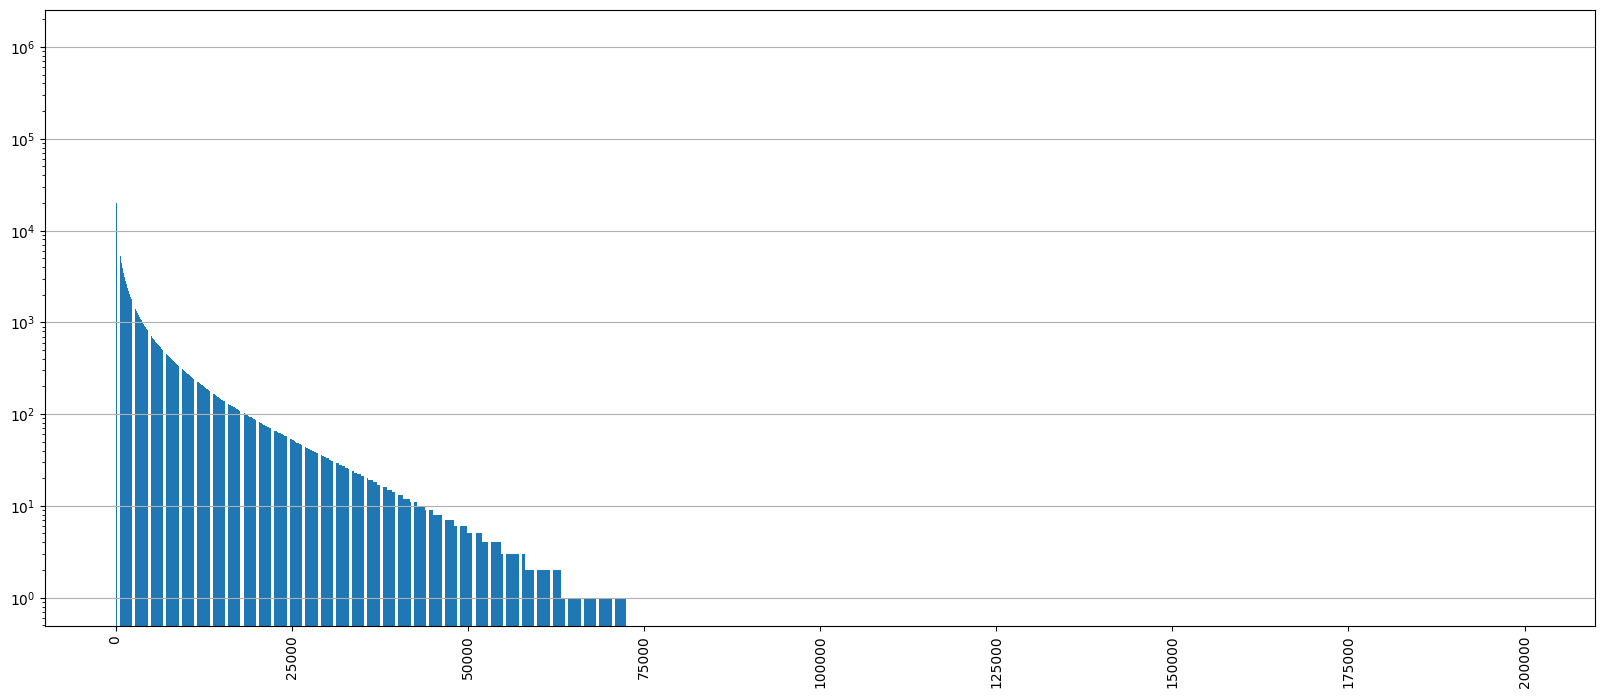

In [ ]:
most_common = 200_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
# labels = np.array(labels[most_common])
values = np.array(values)

plt.bar(range(most_common), values)
plt.xticks(labels=None, rotation='vertical')
plt.grid(axis='y')
plt.yscale("log")
plt.show()

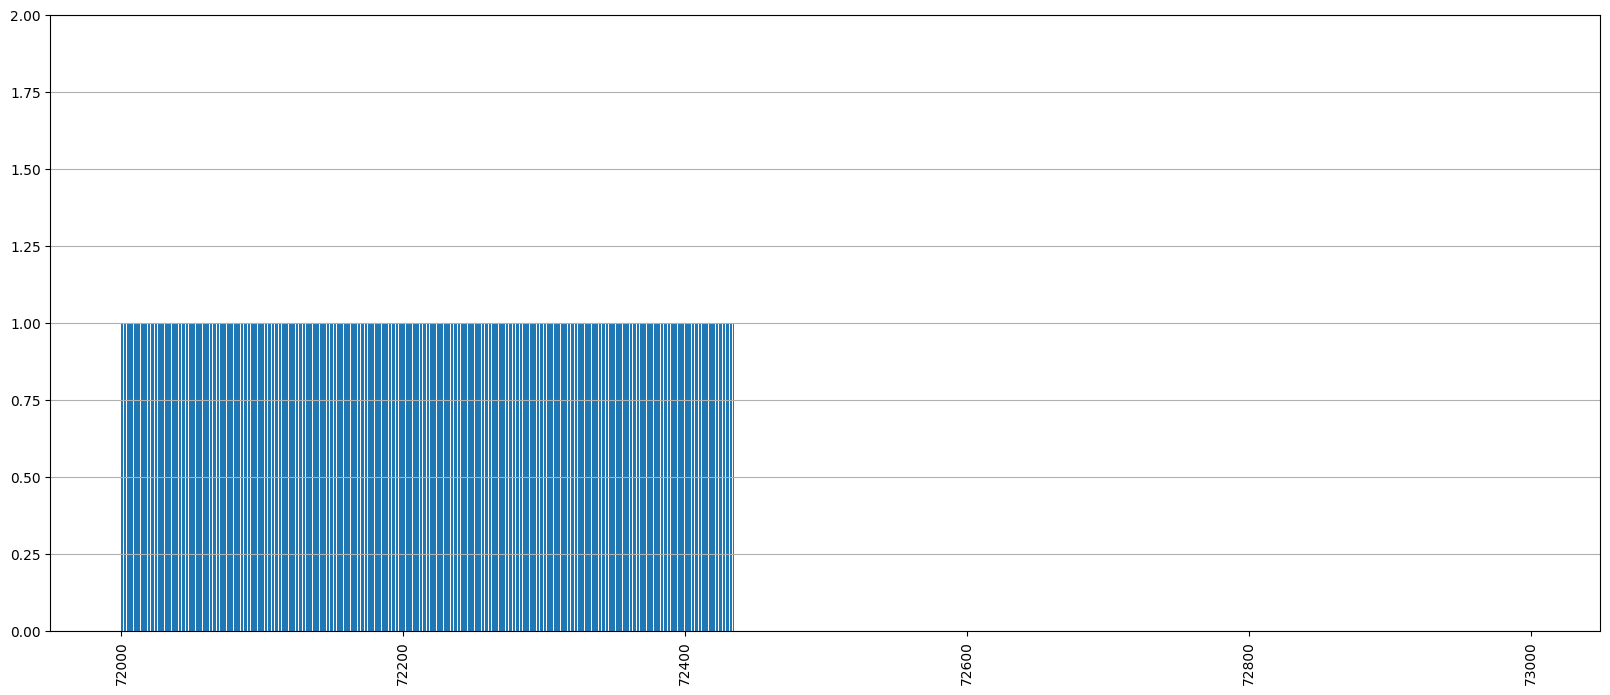

In [30]:
slice_start = 72_000
least_common = 1_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
labels = np.array(labels[slice_start : slice_start + least_common])
values = np.array(values[slice_start : slice_start + least_common])

# plt.bar(labels, values)
plt.bar(range(slice_start, slice_start + least_common), values)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.ylim(top=2)
plt.show()

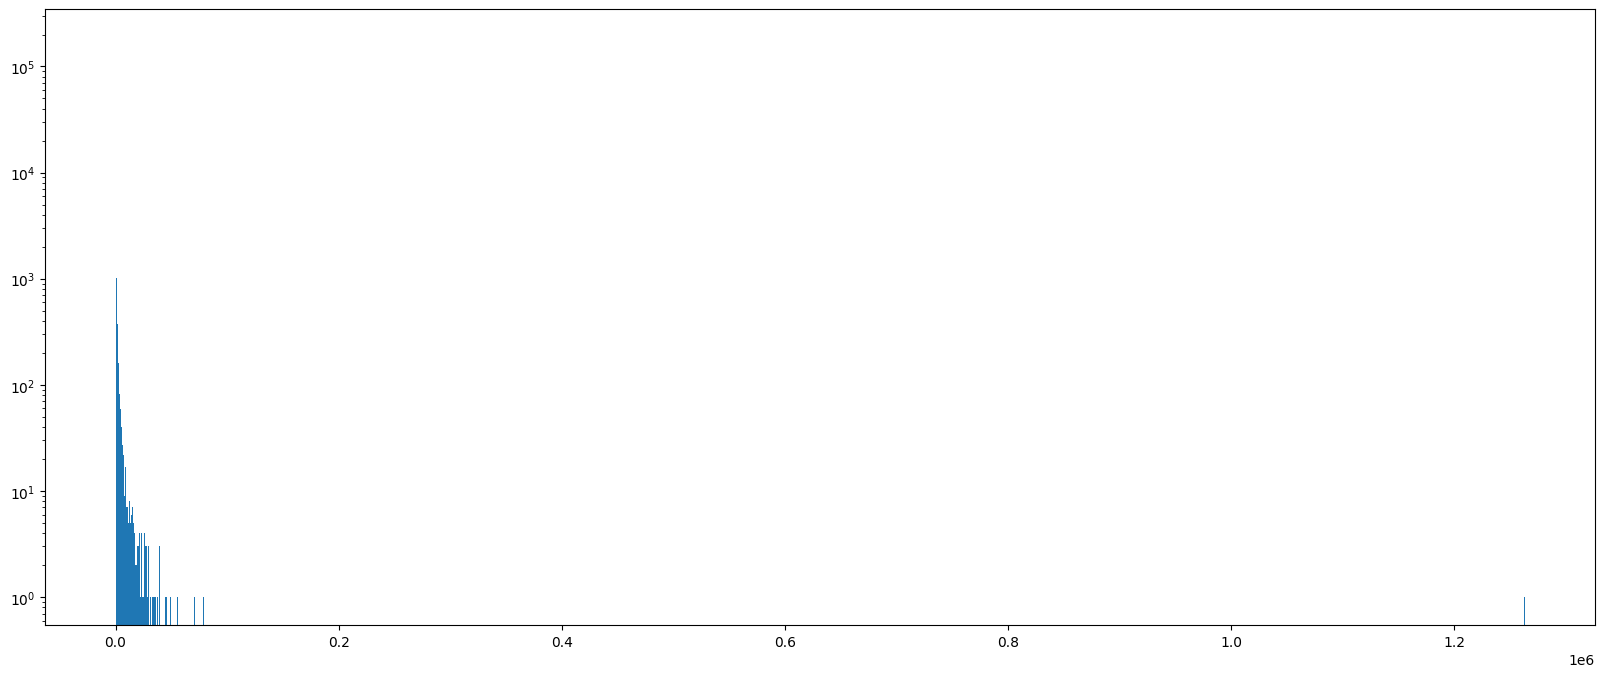

In [34]:
most_common = 10_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )

values = np.array(values[1:most_common])
# np.histogram(values, bins=1_000)

plt.hist(counts, bins=5000)
# plt.ylim(top=5)
# plt.xlim(left=0, right=5_000)
plt.yscale('log')
plt.show()

In [19]:
_, values = zip( *counts_dict_ord.items() )
values = np.array( values )

print( f"n(``) = {values[0].item():,d}" )
print( f"n(!``) = {values[1:].sum().item():,d}" )
print( f"n(!``) = {values[1:50_000].sum().item():,d}" )
print( f"n(!``) = {values[-50_000:].sum().item():,d}" )

n(``) = 1,262,910
n(!``) = 22,318,850
n(!``) = 22,268,363
n(!``) = 0


#### all tokens after **padding**

In [24]:
tag_num = 20

counts = np.zeros(encoding.n_vocab, dtype=np.uint32)


for row in tqdm(tags, colour="#cccc50"):
    # rows = (10_000,)
    for example in row:
        # example = 1 np string of tags

        tokens = encoding.encode(example)[:tag_num]

        # count <pad> token, which is not present
        counts[-1] += tag_num - len(tokens)

        for token in tokens:
            counts[token] += 1
    
    
counts[-1].item()

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


4893232

In [25]:
print("")
counts.sum(), 100*10_000*20

print( 
    f"expectence  = {100*10_000*20:,d}",
    f"actuall sum = {counts.sum():,d}",
    f"="*30,
    f"in percents = {counts.sum() / (10_000*20):,.4f}%",
    sep="\n"
)


expectence  = 20,000,000
actuall sum = 20,000,000
in percents = 100.0000%


In [26]:
counts_dict = {}

for token, index  in encoding._mergeable_ranks.items():
    counts_dict[token] = counts[index].item()

for st, i in encoding._special_tokens.items():
    counts_dict[st.encode("utf-8")] = counts[i].item()

In [27]:
counts_dict_ord = OrderedDict(
    sorted(counts_dict.items(), key=lambda x: x[1], reverse=True)
)

In [28]:
len(counts_dict_ord), len(counts_dict), encoding.n_vocab

(200000, 200000, 200000)

In [29]:
for i, (k, v) in enumerate(counts_dict_ord.items()):
    k = '`' + k.decode("utf-8") + '`'
    print(f"{k:12s}: {v:9,d}")

    if i >= 20:
        break

`<|pad|>`   : 4,893,232
` `         :   698,921
`200`       :    91,016
`d`         :    71,222
`f`         :    67,222
`on`        :    58,713
`8`         :    56,237
` d`        :    49,924
`mm`        :    47,887
`c`         :    43,019
` nik`      :    42,411
`y`         :    40,223
` canon`    :    38,209
`s`         :    34,193
`b`         :    32,657
`ia`        :    30,211
` b`        :    29,732
`365`       :    29,314
` black`    :    29,306
` nature`   :    28,879
`l`         :    28,863


In [30]:
key_list = list(counts_dict_ord.keys())
start = 64_750
end = 64_850
step = (end - start) // 4

print(
    key_list[start : start + step],
    key_list[start + step : start + 2*step],
    key_list[start + 2*step : start + 3*step],
    key_list[start + 3*step : end],
    sep='\n'
)

[b' antigas', b' afloat', b' schenken', b' renewing', b' guarant', b' keinem', b' duha', b'icoes', b' dimensi\xc3\xb3n', b'arbete', b' mangel', b' abiertos', b'=z', b'brightness', b'roog', b' \xd9\x85\xd8\xa7\xd9\x8a', b'exclusive', b'\xe3\x83\x8b\xe3\x83\xb3\xe3\x82\xb0', b' \xd8\xb1\xd8\xad\xd9\x84\xd8\xa9', b' kalor', b' trovato', b'\xe7\x88\xb8\xe7\x88\xb8', b' saha', b' \xec\xa0\x9c\xec\xa3\xbc', b' teatral']
[b' shortening', b'\xd8\xb7\xd8\xa7', b' detaine', b'\xd0\xb1\xd1\x80\xd0\xb5', b' drehen', b' hinged', b' \xe1\x83\xac\xe1\x83\xa7\xe1\x83\x90\xe1\x83\x9a', b' d\xc3\xa9put\xc3\xa9', b' trembling', b'\xc4\xb1kl\xc4\xb1', b' articulation', b' chronology', b' pagando', b' murderous', b' \xd8\xb4\xd9\x87\xd8\xa7\xd8\xaf', b'whose', b' metodolog\xc3\xada', b' jurk', b' dermatologist', b' schneiden', b' prossimo', b'\xe6\xbd\x98', b' szk', b' frivol', b' settimane']
[b' newfound', b'ramin', b' ored', b'identify', b' maduras', b' smarty', b' hopped', b' wohnen', b' civilized', b'u

In [31]:
key_list = list(counts_dict_ord.keys())
start = 72_400
end = 72_500
step = (end - start) // 4

print(
    key_list[start : start + step],
    key_list[start + step : start + 2*step],
    key_list[start + 2*step : start + 3*step],
    key_list[start + 3*step : end],
    sep='\n'
)

[b' ----------------------------------------------------------------', b' Jim', b'_context', b'internal', b' },\r\n', b'Google', b'\xaa\xe0\xaf\x8d\xe0\xae\xaa', b' \xd0\xb3\xd1\x8d', b'Ill', b' \xd0\xbc\xd0\xbd', b' \xd0\xbd\xd0\xb0\xd0\xb2', b'.date', b'\xe0\xb1\x81\xe0\xb0\xa4', b'Messages', b'(o', b'%)', b' \xd1\x81\xd0\xbe\xd0\xb7', b'.fl', b'Asset', b' Estado', b'\xda\xa9\xd9\x86', b' Japanese', b' g\xc3\xa9n\xc3\xa9r', b" they're", b'\xe1\x83\x90\xe1\x83\xa5']
[b'\xd0\xbb\xd0\xb8\xd1\x80\xd0\xb8', b'-width', b'\xd1\x80\xd0\xb0\xd1\x82\xd1\x8c', b'\xe6\x9d\x83', b'\xd0\xb8\xd1\x8f\xd1\x82', b' Very', b'.empty', b' Case', b' \xd1\x80\xd0\xb5\xd1\x88', b'VA', b' Maj', b'\xd9\x81\xd8\xb6', b'\xe1\x80\xbb', b'\xe1\x83\x96', b" $('.", b'.ref', b'\xe0\xa6\x95\xe0\xa7\x8d\xe0\xa6\xb7', b'AMP', b'\xd1\x86\xd0\xb8\xd1\x8e', b'Bound', b'\xd0\xba\xd0\xb0\xd1\x8f', b' DES', b' Dom', b' proceed', b'Bon']
[b'-off', b'\xd8\xa7\xd8\xa6\xd9\x8a', b'Validator', b'\xe0\xa4\xbe\xe0\xa4\xa7', b'\xe1\

##### graphs

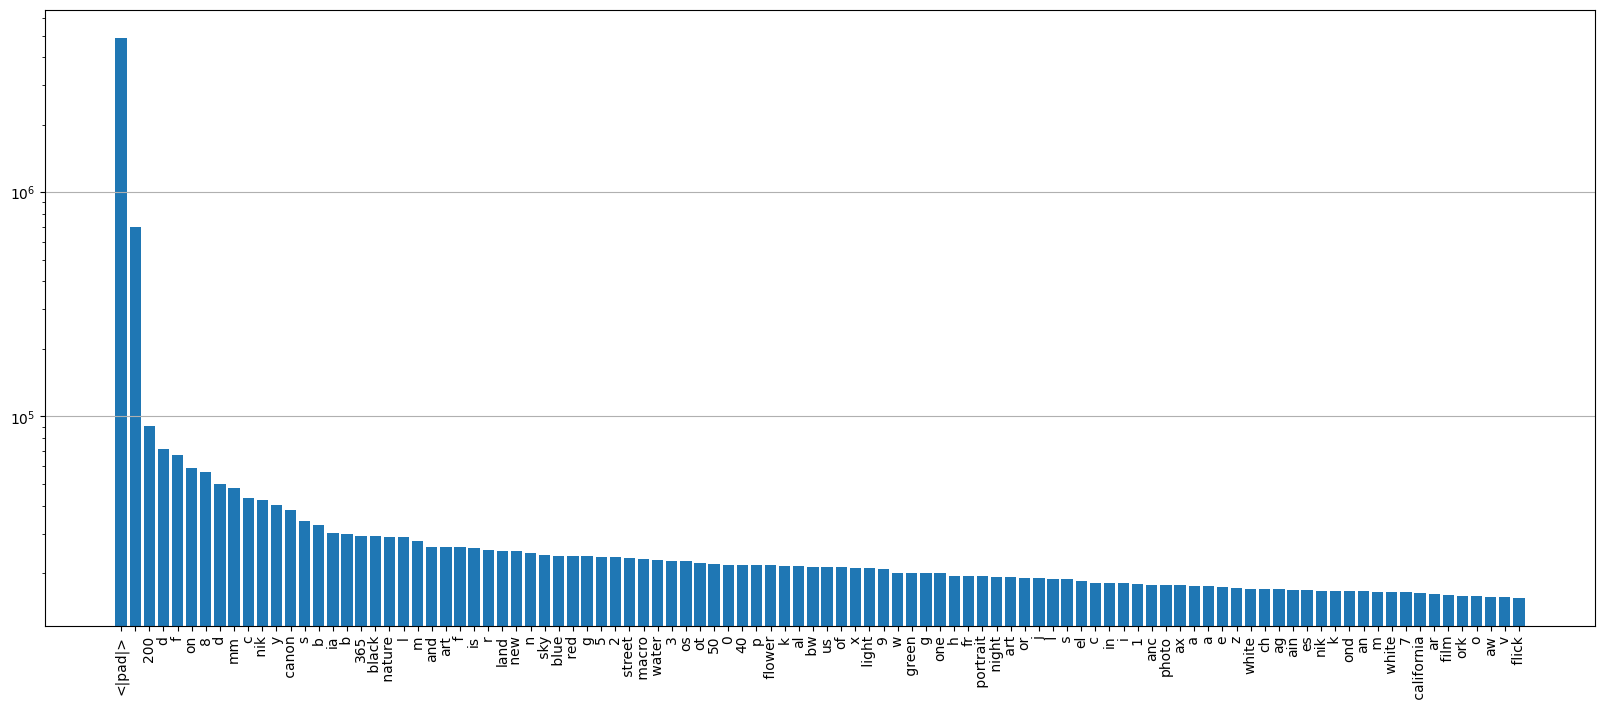

In [25]:
most_common = 100

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
labels = np.array(labels[:most_common])
values = np.array(values[:most_common])


plt.bar(labels, values)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

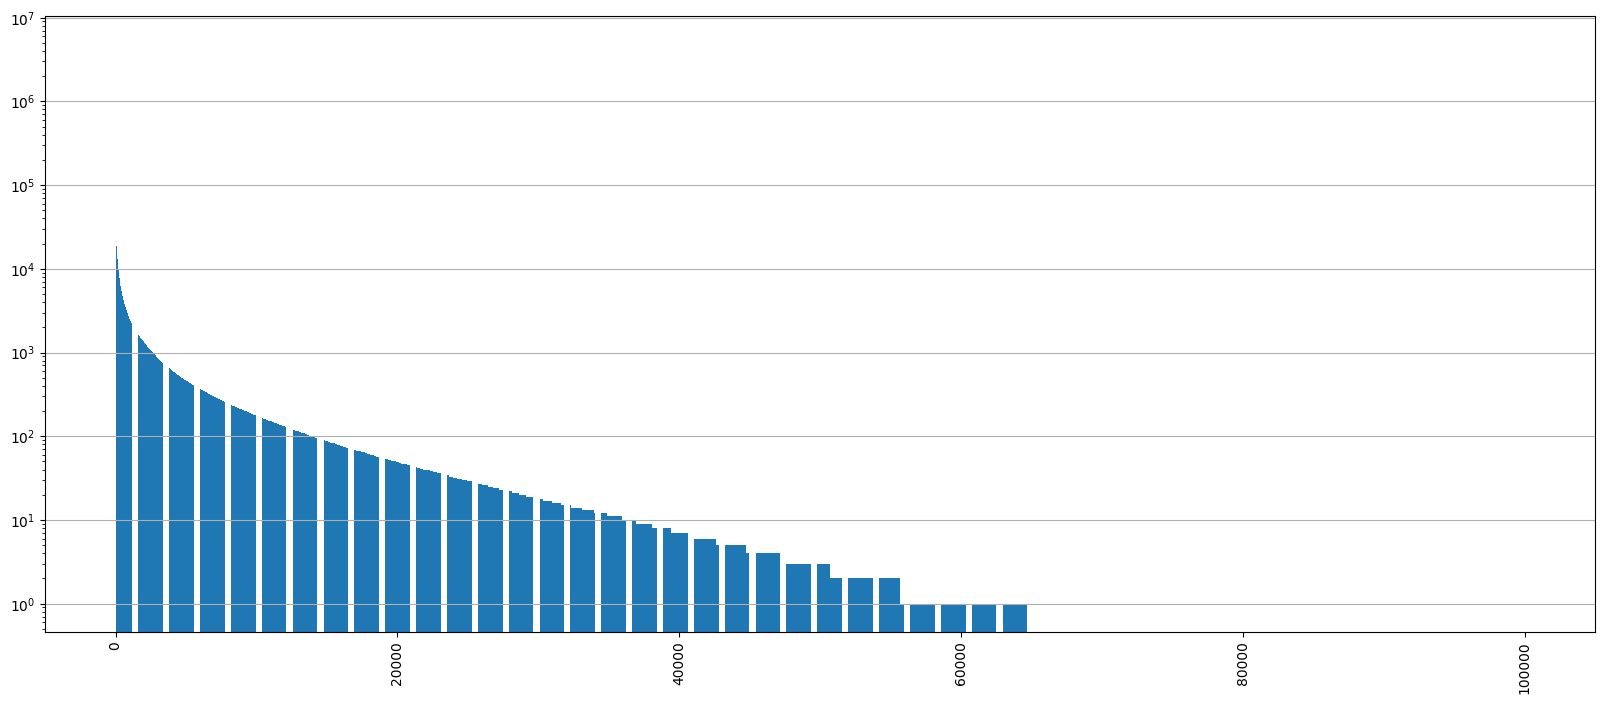

In [28]:
most_common = 100_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
# labels = np.array(labels[most_common])
values = np.array(values[:most_common])

plt.bar(range(most_common), values)
plt.xticks(labels=None, rotation='vertical')
plt.grid(axis='y')
plt.yscale("log")
plt.show()

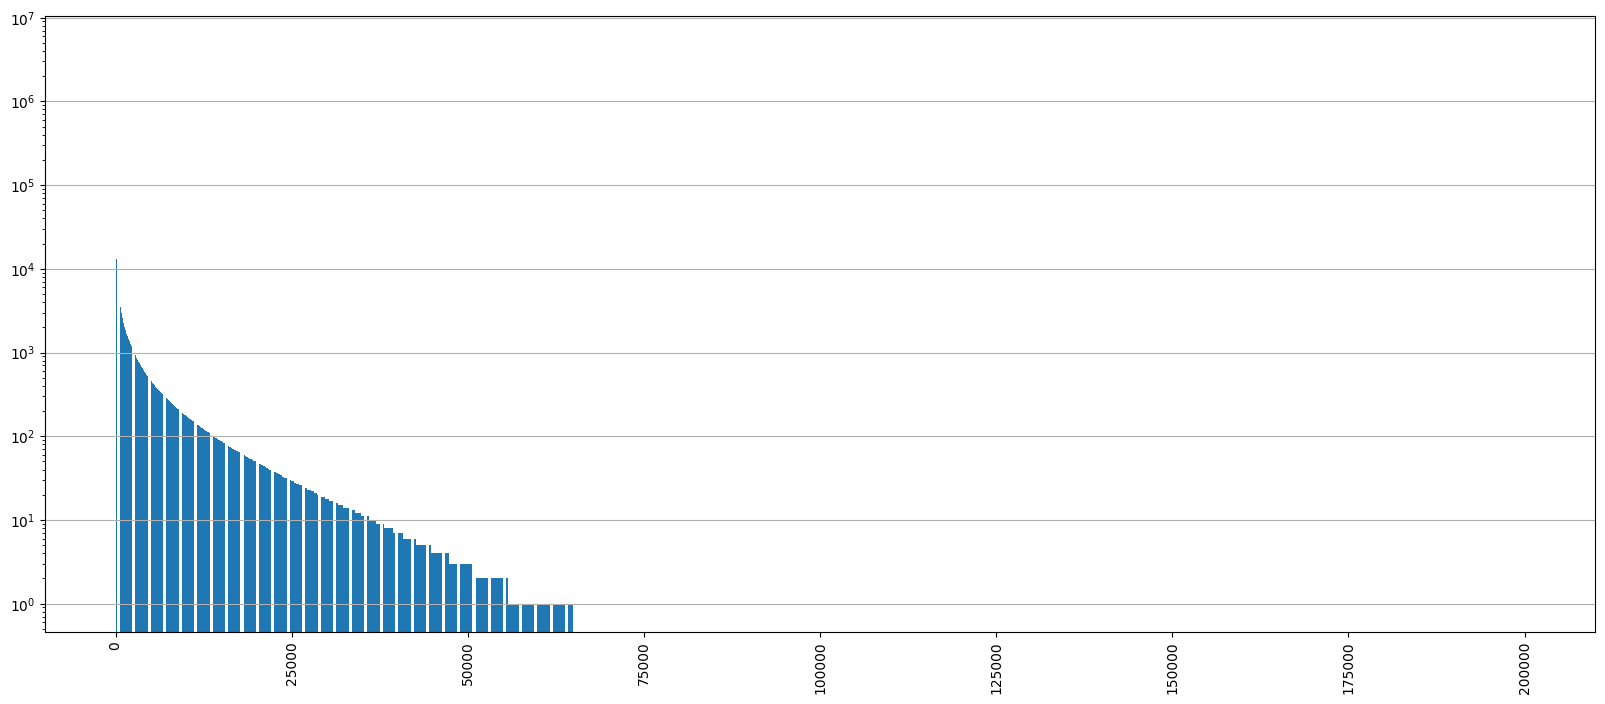

In [29]:
most_common = 200_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
# labels = np.array(labels[most_common])
values = np.array(values)

plt.bar(range(most_common), values)
plt.xticks(labels=None, rotation='vertical')
plt.grid(axis='y')
plt.yscale("log")
plt.show()

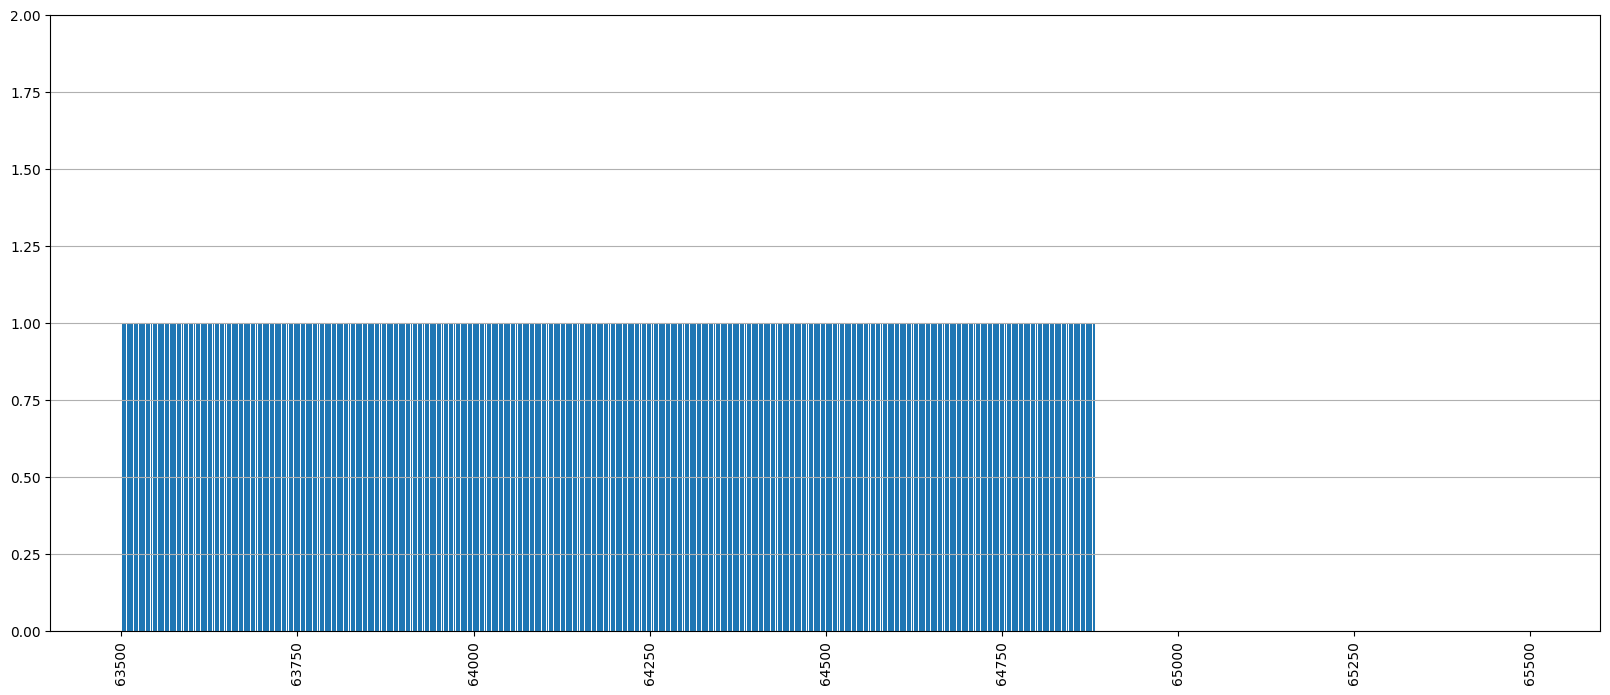

In [31]:
slice_start = 63_500
least_common = 2_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )
labels = np.array(labels[slice_start : slice_start + least_common])
values = np.array(values[slice_start : slice_start + least_common])

# plt.bar(labels, values)
plt.bar(range(slice_start, slice_start + least_common), values)
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.ylim(top=2)
plt.show()

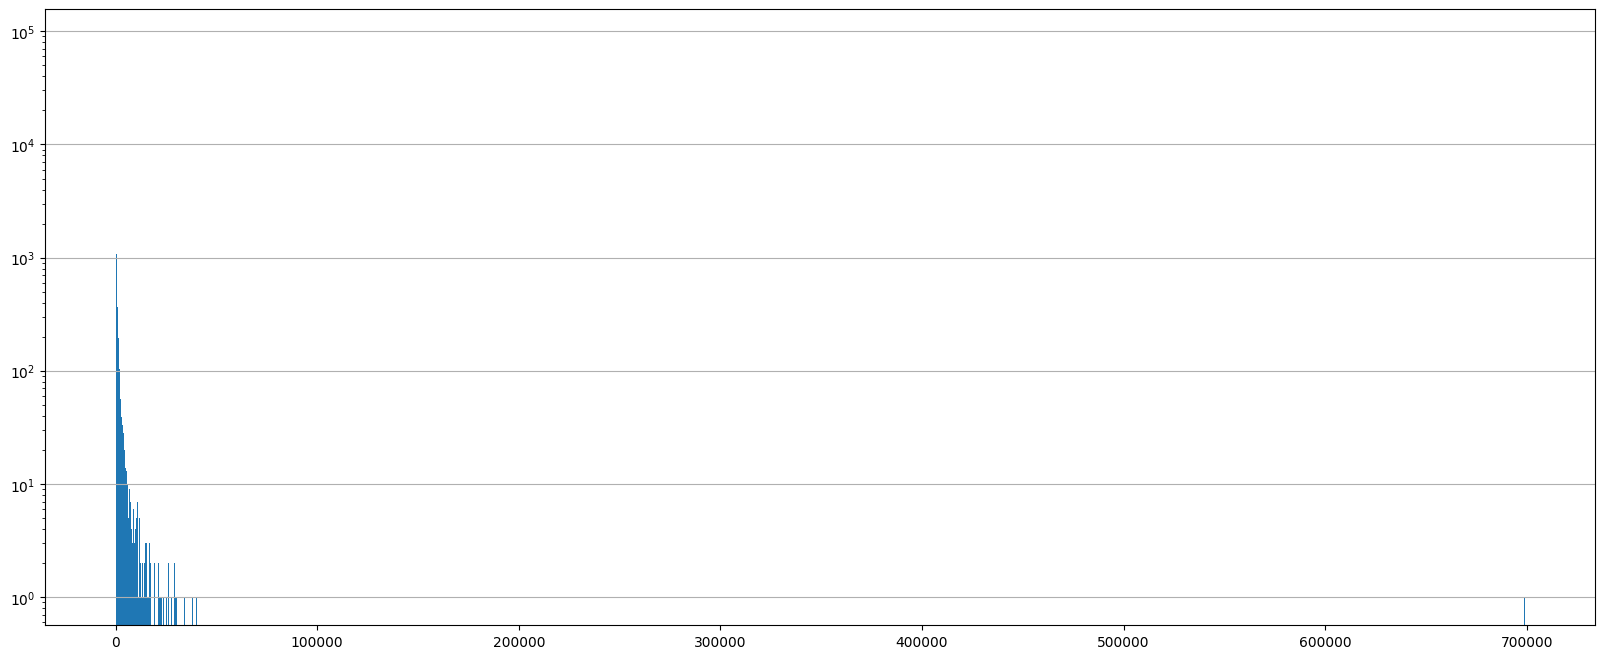

In [45]:
most_common = 100_000

plt.figure(figsize=(20, 8))

labels, values = zip( *counts_dict_ord.items() )

values = np.array(values[1:most_common])
# np.histogram(values, bins=1_000)

plt.hist(values, bins=5000)
# plt.ylim(top=50000)
# plt.xlim(left=0, right=10_000)
plt.grid(axis="y")
plt.yscale('log')
plt.show()

In [50]:
_, values = zip( *counts_dict_ord.items() )
values = np.array( values )

print( f"n(`<|pad|>`) = {values[0].item():,d}" )
print( f"n(!`<|pad|>`) = {values[1:].sum().item():,d}" )
print( f"n(!`<|pad|>`) = {values[1:50_000].sum().item():,d}" )
print( f"n(!`<|pad|>`) = {values[-150_000:].sum().item():,d}" )

n(`<|pad|>`) = 4,893,232
n(!`<|pad|>`) = 15,106,768
n(!`<|pad|>`) = 15,085,483
n(!`<|pad|>`) = 21,285


## imgs research

### Lab

#### prep

In [30]:
L_ch = np.zeros(256, dtype=np.int64)
a_ch = np.zeros(256, dtype=np.int64)
b_ch = np.zeros(256, dtype=np.int64)

folder_nums = [str(n).zfill(2) + ".npy" for n in range(100)]


for num in tqdm(folder_nums, colour="#10cbcb"):
    ab_path = ab_folder / num
    L_path = L_folder / num

    ###  for L channel  ###
    file = np.load(L_path)

    inds, counts = np.unique(file, return_counts=True)
    # returns [0] -> all unique values (we know it's in [0, 255])
    #  [1] -> hw many of them

    # L
    L_ch[inds] += counts
    

    ###  for ab channels  ###
    file = np.load(ab_path)

    # a
    inds, counts = np.unique(file[:, :, :, 0], return_counts=True)
    a_ch[inds] += counts

    # b
    inds, counts = np.unique(file[:, :, :, 1], return_counts=True)
    b_ch[inds] += counts

    break
    


  0%|          | 0/100 [00:43<?, ?it/s]


In [44]:
print(
    f"total amount of pixels = {10_000 * 224 * 224:,}",
    "="*40,
    f"actual:",
    f"L = {int(L_ch.sum().item()):,}",
    f"a = {int(a_ch.sum().item()):,}",
    f"b = {int(b_ch.sum().item()):,}",
    sep="\n"
)

total amount of pixels = 501,760,000
actual:
L = 501,760,000
a = 501,760,000
b = 501,760,000


#### all files

In [54]:
L_ch = np.zeros(256, dtype=np.int64)
a_ch = np.zeros(256, dtype=np.int64)
b_ch = np.zeros(256, dtype=np.int64)

folder_nums = [str(n).zfill(2) + ".npy" for n in range(100)]


for num in tqdm(folder_nums, colour="#10cbcb"):
    ab_path = ab_folder / num
    L_path = L_folder / num

    ###  for L channel  ###
    file = np.load(L_path)

    inds, counts = np.unique(file, return_counts=True)
    # returns [0] -> all unique values (we know it's in [0, 255])
    #  [1] -> hw many of them

    # L
    L_ch[inds] += counts
    

    ###  for ab channels  ###
    file = np.load(ab_path)

    # a
    inds, counts = np.unique(file[:, :, :, 0], return_counts=True)
    a_ch[inds] += counts

    # b
    inds, counts = np.unique(file[:, :, :, 1], return_counts=True)
    b_ch[inds] += counts
    

100%|██████████| 100/100 [1:18:26<00:00, 47.07s/it]


#### graphs

In [4]:
labels = range(256)

ticks = [0, 20, 25, 50, 100, 150, 200, 225, 230, 250]

In [ ]:
# a_ch = np.load(data_folder / "statistics/a_channels.npy")
# b_ch = np.load(data_folder / "statistics/b_channels.npy")

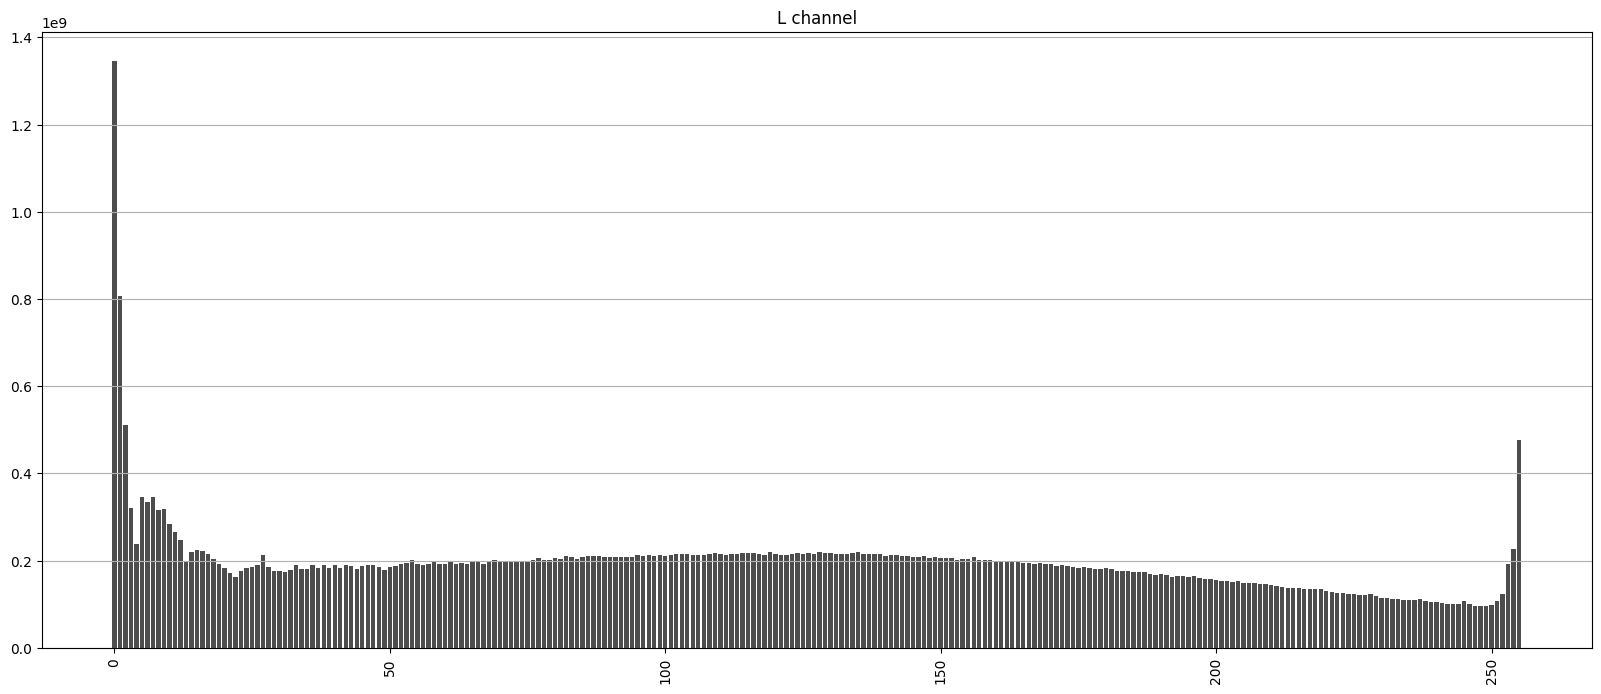

In [57]:
plt.figure(figsize=(20, 8))
plt.title("L channel")

plt.bar(labels, L_ch, color="#4d4d4d")
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.show()

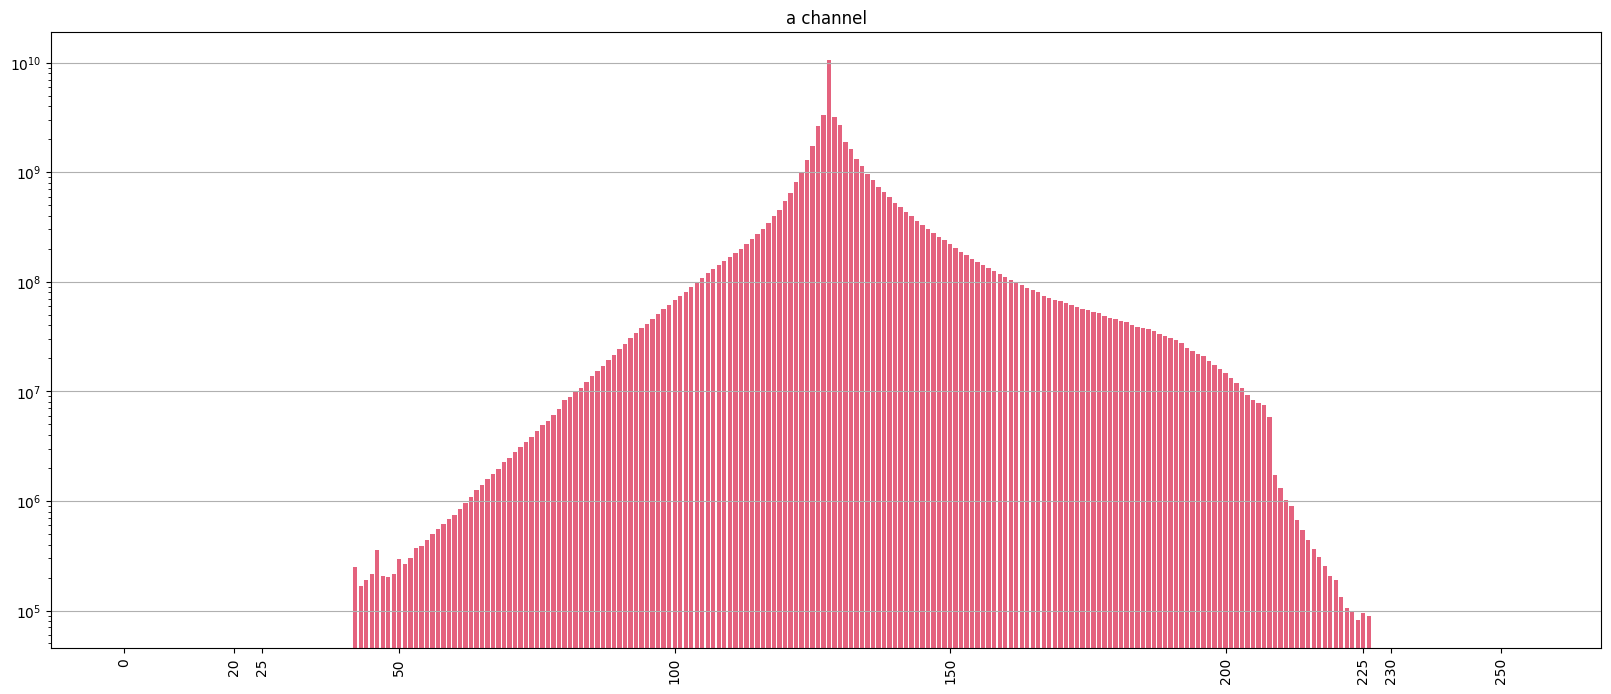

In [8]:
plt.figure(figsize=(20, 8))
plt.title("a channel")

plt.bar(labels, a_ch, color="#e4627e")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

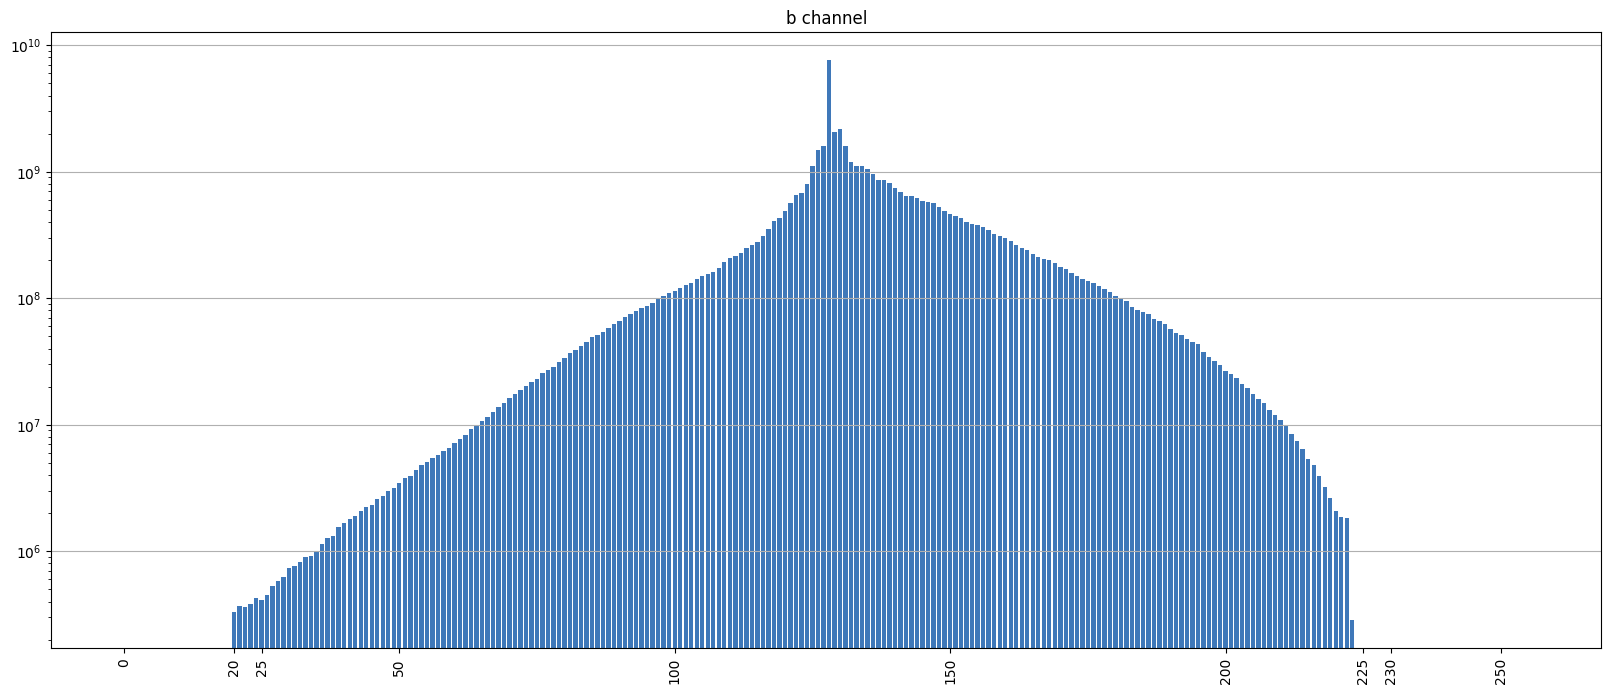

In [59]:
plt.figure(figsize=(20, 8))
plt.title("b channel")

plt.bar(labels, b_ch, color="#3f78b9")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

#### save

In [60]:
np.save(data_folder / "statistics/L_channels.npy", L_ch)
np.save(data_folder / "statistics/a_channels.npy", a_ch)
np.save(data_folder / "statistics/b_channels.npy", b_ch)

### RGB

#### all files

In [10]:
R_ch = np.zeros(256, dtype=np.int64)
G_ch = np.zeros(256, dtype=np.int64)
B_ch = np.zeros(256, dtype=np.int64)

batch_size = 10_000
img = np.zeros((batch_size, 224, 224, 3))

folder_nums = [str(n).zfill(2) + ".npy" for n in range(100)]


for num in tqdm(folder_nums, colour="#10cbcb"):
    ab_path = ab_folder / num
    L_path = L_folder / num

    ###  for L channel  ###
    L_data = np.load(L_path)
    ab_data = np.load(ab_path)

    # print(L_data.shape, ab_data.shape)
    # print(L_data[:, :, :, None].shape)

    img = np.concat([L_data[:, :, :, None], ab_data], axis=-1)
    img = np.array([
        cv2.cvtColor(example, cv2.COLOR_LAB2RGB)
        for example in img
    ])


    ## R
    inds, counts = np.unique(img[:, :, :, 0], return_counts=True)
    R_ch[inds] += counts

    ## G
    inds, counts = np.unique(img[:, :, :, 1], return_counts=True)
    G_ch[inds] += counts

    ## B
    inds, counts = np.unique(img[:, :, :, 2], return_counts=True)
    B_ch[inds] += counts

    



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [1:39:40<00:00, 59.80s/it]


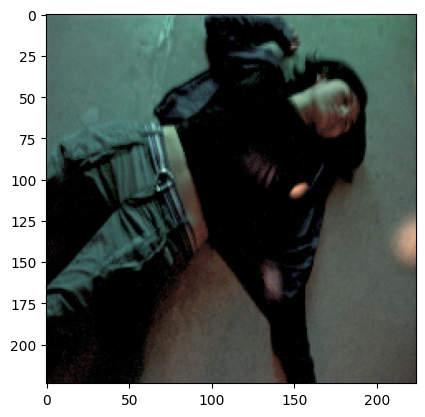

In [11]:
plt.imshow(img[0])  # img is really RGB
plt.show()

#### graphs

In [12]:
labels = range(256)

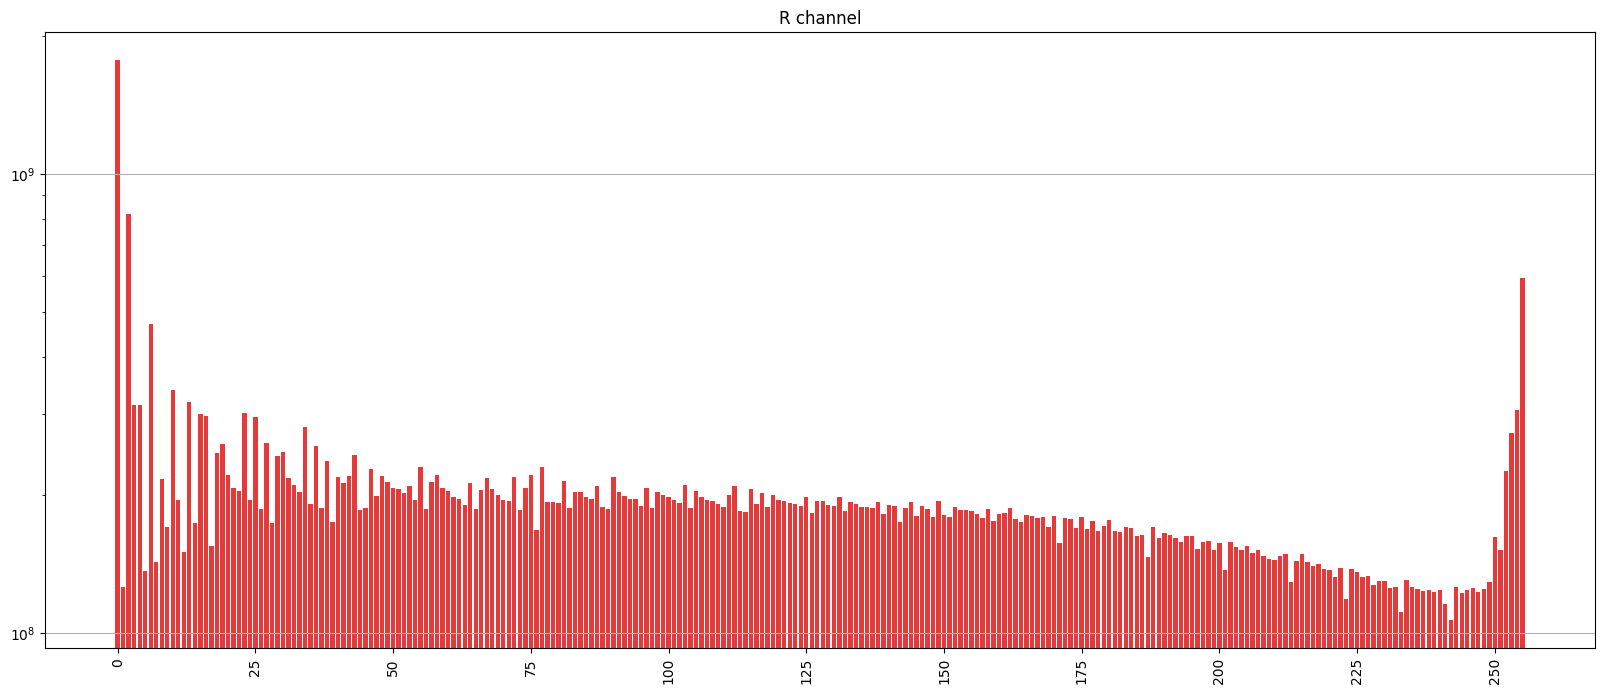

In [30]:
plt.figure(figsize=(20, 8))
plt.title("R channel")

plt.bar(labels, R_ch, color="#e63a3a")
plt.xticks(ticks=range(0, 256, 25), rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

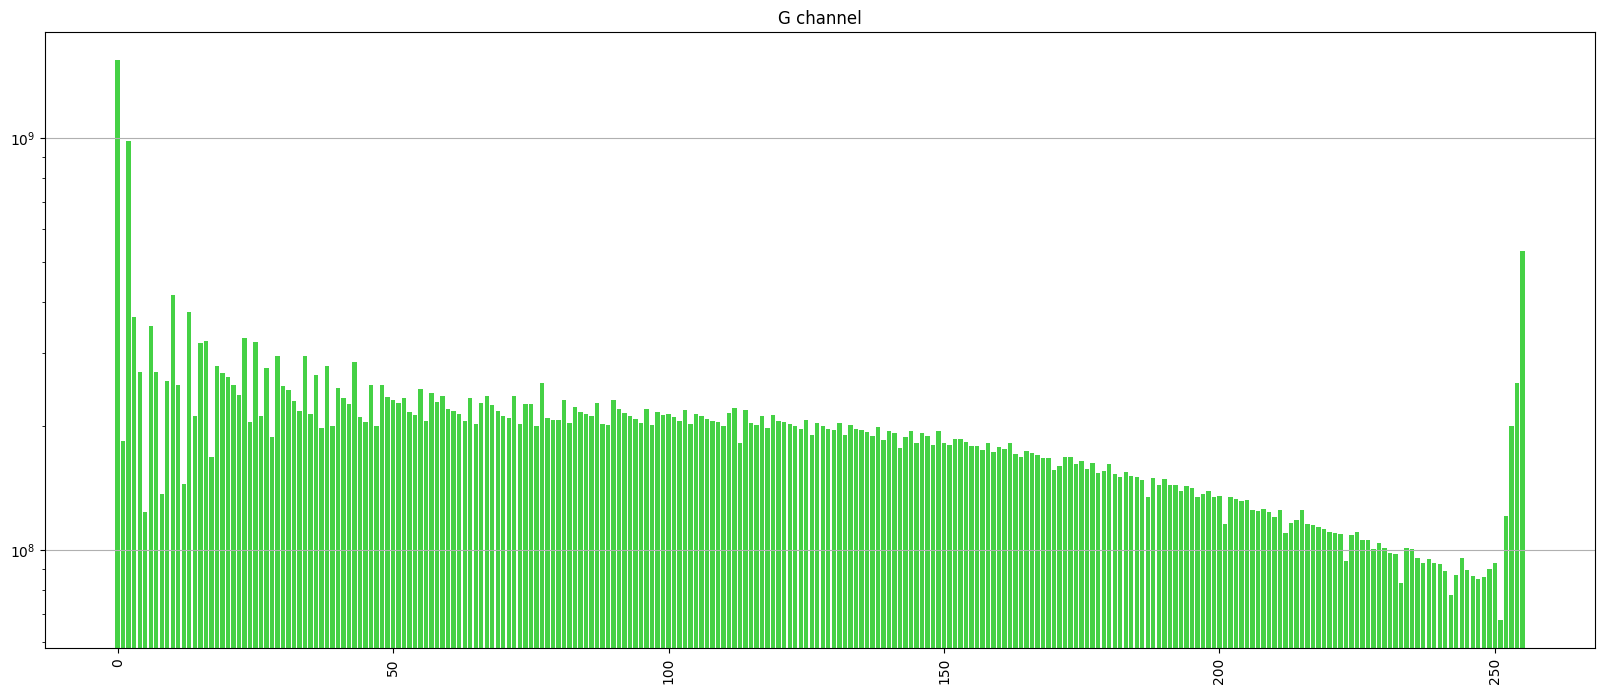

In [17]:
plt.figure(figsize=(20, 8))
plt.title("G channel")

plt.bar(labels, G_ch, color="#45d145")
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

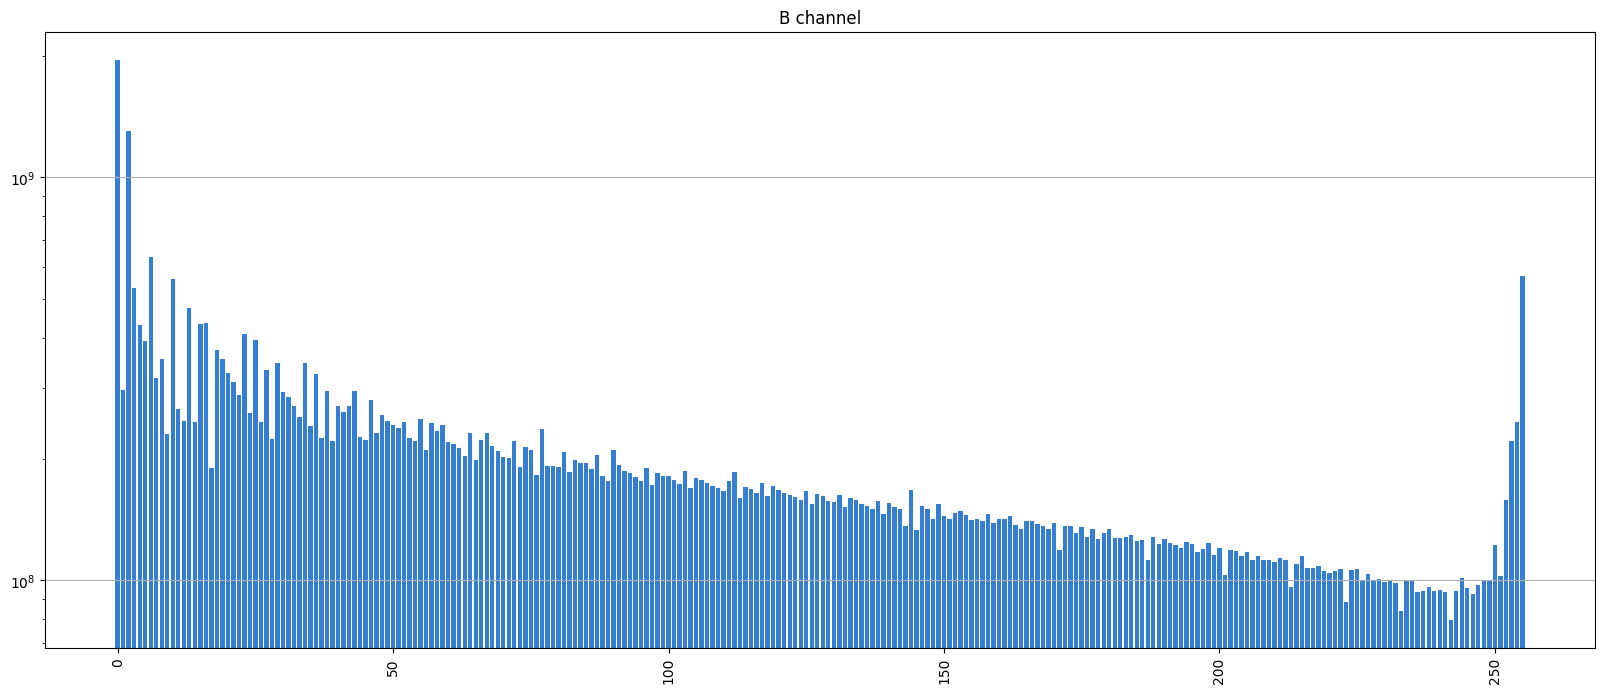

In [18]:
plt.figure(figsize=(20, 8))
plt.title("B channel")

plt.bar(labels, B_ch, color="#367ed1")
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

#### save

In [19]:
np.save(data_folder / "statistics/R_channels.npy", R_ch)
np.save(data_folder / "statistics/G_channels.npy", G_ch)
np.save(data_folder / "statistics/B_channels.npy", B_ch)

### BGR

#### prep

In [35]:
B_ch = np.zeros(256, dtype=np.int64)
G_ch = np.zeros(256, dtype=np.int64)
R_ch = np.zeros(256, dtype=np.int64)

img_files = (data_folder / "images").glob("**/*.jpg")


for img_file in tqdm(img_files, colour="#10cbcb"):
    img = cv2.imread(img_file)

    
    ## B
    inds, counts = np.unique(img[:, :, 0], return_counts=True)
    B_ch[inds] += counts

    ## G
    inds, counts = np.unique(img[:, :, 1], return_counts=True)
    G_ch[inds] += counts

    ## R
    inds, counts = np.unique(img[:, :, 2], return_counts=True)
    R_ch[inds] += counts
    
    break


0it [00:00, ?it/s]


In [36]:
print(
    f"total amount of pixels = {np.prod(img.shape[:-1]):,}",
    "="*40,
    f"actual:",
    f"B = {int(B_ch.sum().item()):,}",
    f"G = {int(G_ch.sum().item()):,}",
    f"R = {int(R_ch.sum().item()):,}",
    sep="\n"
)

total amount of pixels = 166,500
actual:
B = 166,500
G = 166,500
R = 166,500


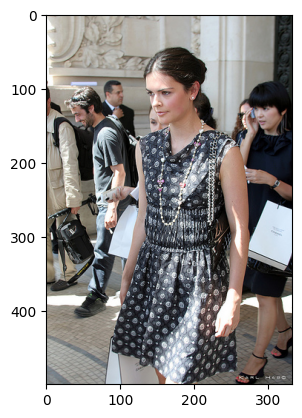

In [ ]:
plt.subplots(1, 2, 1)
plt.imshow(img)

plt.subplots(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # img is really BRG

plt.show()

#### all files

In [40]:
B_ch = np.zeros(256)
G_ch = np.zeros(256)
R_ch = np.zeros(256)

img_files = (data_folder / "images").glob("**/*.jpg")


for img_file in tqdm(img_files, colour="#10cbcb", total=int(1e6)):
    img = cv2.imread(img_file)

    
    ## B
    inds, counts = np.unique(img[:, :, 0], return_counts=True)
    B_ch[inds] += counts

    ## G
    inds, counts = np.unique(img[:, :, 1], return_counts=True)
    G_ch[inds] += counts

    ## R
    inds, counts = np.unique(img[:, :, 2], return_counts=True)
    R_ch[inds] += counts
    


100%|██████████| 1000000/1000000 [7:20:37<00:00, 37.83it/s]


#### graphs

In [41]:
labels = range(256)

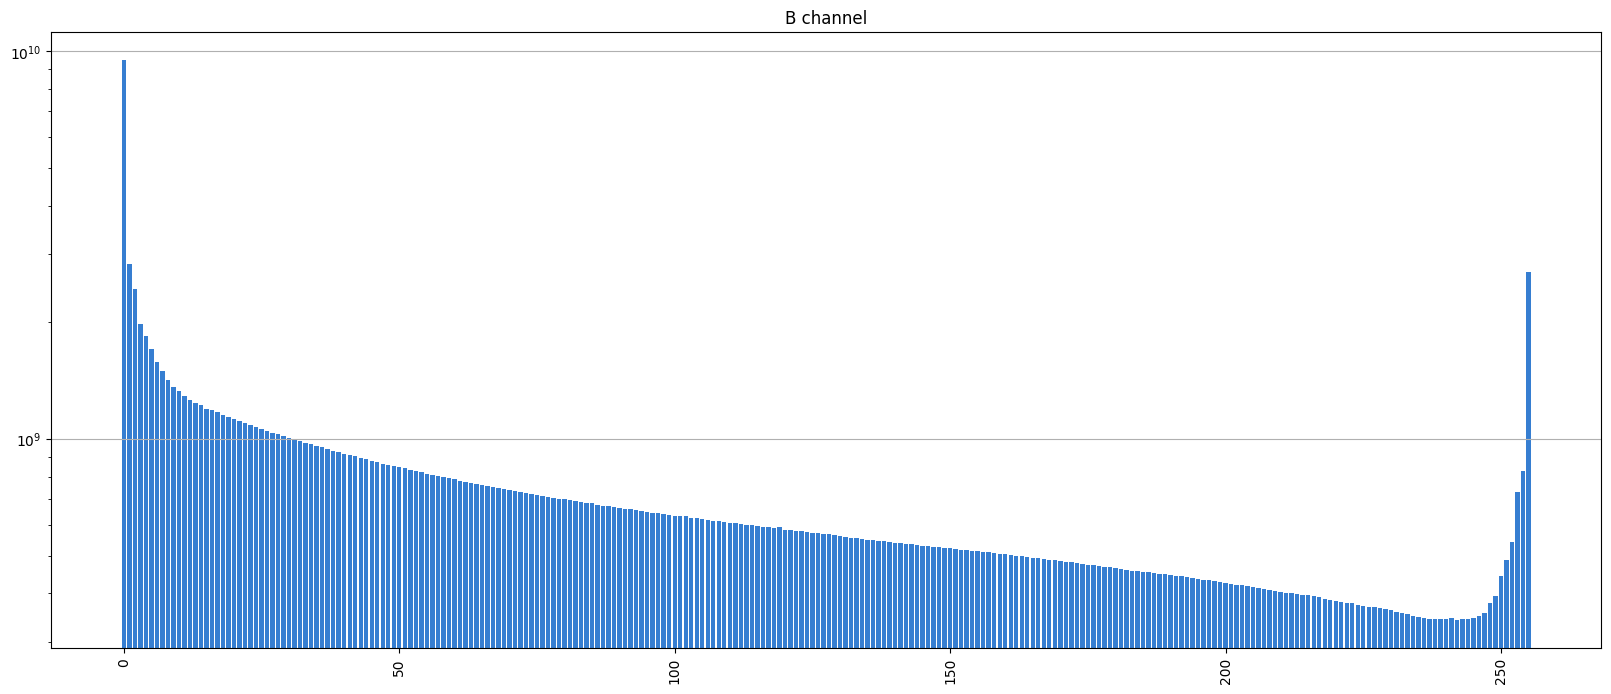

In [42]:
plt.figure(figsize=(20, 8))
plt.title("B channel")

plt.bar(labels, B_ch, color="#367ed1")
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

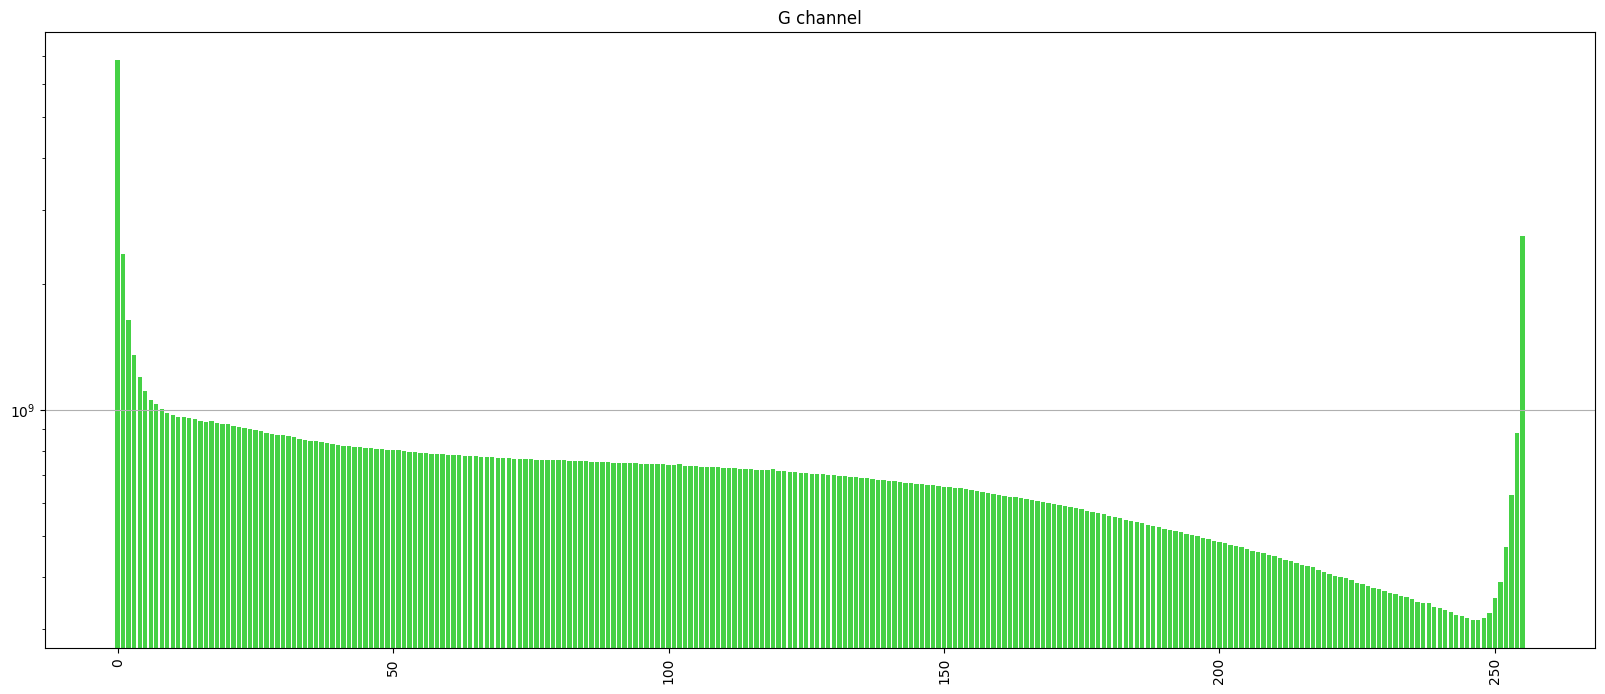

In [43]:
plt.figure(figsize=(20, 8))
plt.title("G channel")

plt.bar(labels, G_ch, color="#45d145")
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

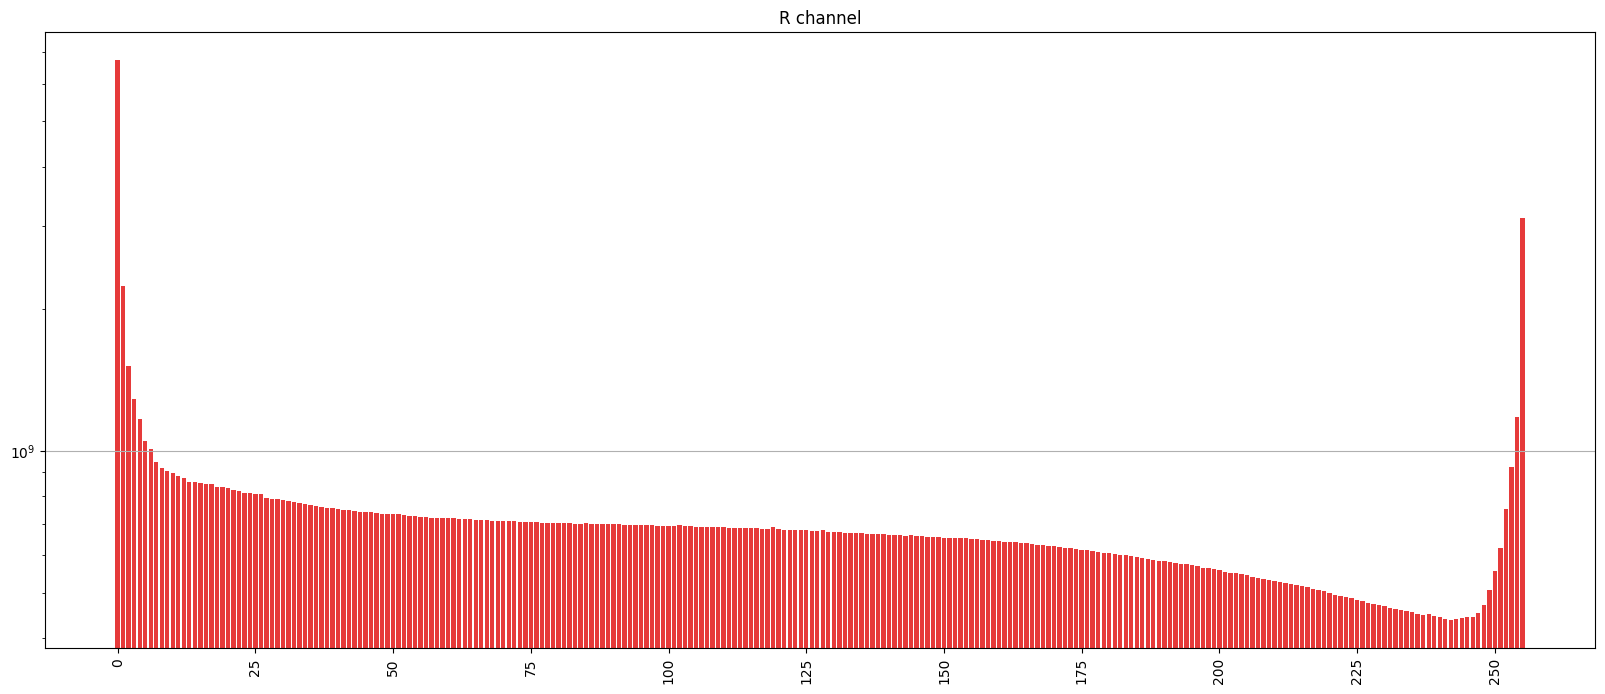

In [44]:
plt.figure(figsize=(20, 8))
plt.title("R channel")

plt.bar(labels, R_ch, color="#e63a3a")
plt.xticks(ticks=range(0, 256, 25), rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

#### save

In [45]:
np.save(data_folder / "statistics/B_channels_raw.npy", B_ch)
np.save(data_folder / "statistics/G_channels_raw.npy", G_ch)
np.save(data_folder / "statistics/R_channels_raw.npy", R_ch)

### generated

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import lightning as L

model_folder = Path( os.environ["MODEL_FOLDER"] )
model_path = model_folder / "cwgan_gp.pth"

wti_path  = data_folder / "words_to_inds.npy"
L_path    = data_folder / "L"
tags_path = data_folder / "tags.npy"

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # 'cuda:0'

batch_size = 96
tag_num = 8
emb_dim = 100

In [4]:
words_to_inds = np.load(wti_path, allow_pickle='TRUE').item()
# inds_to_words = {ind:word for word, ind in words_to_inds.items()}

vocab_size = len(words_to_inds)

#### model initialization

##### Вспомогательные функции для генератора

In [5]:
###  для генератора

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Identity Mapping
        self.conv_for_ident = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride)
        
        self.relu = nn.ReLU(inplace=True)

  
    def forward(self, x):
        identity = x.clone().detach()

        x = self.block(x)
        identity = self.conv_for_ident(identity)

        output = x + identity
        output = self.relu(output)
        return output


## вниз
class UEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(UEncoder, self).__init__()

        self.down_layer = nn.Sequential(
            nn.MaxPool2d(2, 2),
            ResBlock(in_channels, out_channels, stride=stride)
        )

    def forward(self, x):
        output = self.down_layer(x)
        return output


## вверх
class UDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UDecoder, self).__init__()

        self.upsamp = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.residual_block = ResBlock(in_channels+out_channels, out_channels)      #потому что перед Conv2d происходит конкатенация с identity (skip)
  
    def forward(self, x, skip):
        x = self.upsamp(x)

        x = torch.cat( [x, skip], dim=1)

        output = self.residual_block(x)
        return output


In [6]:
## обработка тегов к виду входных данных
##   (batch_size, tag_num) --> (batch_size, 1, 224, 224)
# отдельным классом, т.к. процесс будет идентичен и в генераторе, и в критике
class Embedding_tags(nn.Module):
    def __init__(self, cond_channels=1,
                 vocab_size=vocab_size, emb_dim=4):
        super(Embedding_tags, self).__init__()
        
        self.lstm_hidden_dim = 32
        self.lstm_num_layers = 2
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
            #(b_s, tag_num) -> (b_s, tag_num, emb_dim)
        self.lstm = nn.LSTM(emb_dim, self.lstm_hidden_dim,
                            num_layers=self.lstm_num_layers, batch_first=True)
            #(b_s, tag_num, emb_dim) -> (b_s, 32)
        self.lin1 = nn.Linear(self.lstm_hidden_dim, 14*14)
            #(b_s, 32) -> (b_s, 14*14)
        self.lin2 = nn.Linear(14*14, 56*56)
            #(b_s, 14*14) -> (b_s, 56*56)
            
        #then in forward reshape to -> (b_s, 1, 56, 56)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 1, 56, 56) -> (b_s, 32, 56, 56)
        self.bn1 = nn.BatchNorm2d(32)
        #upsample:
            #(b_s, 32, 56, 56) -> (b_s, 32, 112, 112)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 32, 112, 112) -> (b_s, 64, 112, 112)
        self.bn2 = nn.BatchNorm2d(64)
        #upsample again:
            #(b_s, 64, 112, 112) -> (b_s, 64, 224, 224)
        self.conv3 = nn.Conv2d(64, cond_channels, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 64, 224, 224) -> (b_s, 1, 224, 224)
        self.bn3 = nn.BatchNorm2d(cond_channels)
        #желаемая размерность получена

        self.relu = nn.ReLU(inplace=True)

    
    def forward(self, x):
        ## ---- 1d -------------------
        bs, seq_len = x.shape
        x = self.emb(x)

        hidden = torch.zeros((self.lstm_num_layers, bs, self.lstm_hidden_dim)).to(x.device)
        cell   = torch.zeros((self.lstm_num_layers, bs, self.lstm_hidden_dim)).to(x.device)
                         # (lstm.num_layers, batch_size, hidden_dim)
        """ собственноручное усложнение своей жизни
        for tag_ind in range(seq_len):
            # x.shape = (b_s, tag_num, emb_dim); => each tag embedding = [:, tag_ind, :]
            # we want to feed to lstm each tag embedding consecutively,
            # но если мы хотим использовать долгую и короткую памяти, необходимо сохранять размерность,
            # поэтому каждый отдельный тег имеет shape = [b_s, 1, emb_dim]
            output, (hidden, cell) = self.lstm(x[:, tag_ind, :].unsqueeze(1), (hidden, cell))
        """
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        output = output[:, -1, :]  # только результат lstm по Всем тегам
        
        output = self.lin1(output)
        output = self.relu(output)
        output = self.lin2(output)
        # output = self.relu(output)
        
        ## ---- 2d -------------------
        output = output.view(-1, 1, 56, 56)
        
        output = self.bn1( self.conv1(output) )
        output = self.up(output)
        output = self.bn2( self.conv2(output) )
        #
        output = self.up(output)
        output = self.bn3( self.conv3(output) )
        
        return output

##### Сам Генератор

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels,
                 vocab_size, emb_dim=4, dropout_rate=0.5):
        super(Generator, self).__init__()
        
        ## обработка тегов (Conditions)
        self.emb = Embedding_tags(cond_channels, vocab_size, emb_dim)
        
        ## 2 первых слоя конволюции перед началом ResNet'a
        self.enc_layer0 = ResBlock(in_channels+cond_channels, 64)
            #in_channels - изначальные входные данные
            # + cond_channels  - приконкатеннированные условия

        ## спускаемся вниз по U-Net'у
        self.enc_layer1 = UEncoder(64, 128)
        self.enc_layer2 = UEncoder(128, 256)
        self.enc_layer3 = UEncoder(256, 512)
        self.enc_layer4 = UEncoder(512, 1024)

        ## "центральная" часть (мост)
        self.bridge = UEncoder(1024, 2048)

        ## возвращаемся к первоначчальным размерам
        self.dec_layer4 = UDecoder(2048, 1024)
        self.dec_layer3 = UDecoder(1024, 512)
        self.dec_layer2 = UDecoder(512, 256)
        self.dec_layer1 = UDecoder(256, 128)
        self.dec_layer0 = UDecoder(128, 64)

        ## переводим необходимое нам кол-во каналов в качестве output генератора
        ##   (получили 1 канал: L; на выходе 2 канала: a,b)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)

        # применяется после Conv2d для меньшей зависимости между каналами feature maps
        self.drop = nn.Dropout2d(dropout_rate)

  
    def forward(self, x, conds):
        #форматируем условия до размерности `x`
        conds = self.emb(conds)
        
        #конкатенируем входные данные и условия
        x = torch.cat( [x, conds], dim=1)
        
        # спуск вниз
        e0 = self.enc_layer0(x)   #разные буквы, так как нам нужны skip connections
        e0 = self.drop(e0)   #skip №0
        e1 = self.enc_layer1(e0)
        e1 = self.drop(e1)   #skip №1
        e2 = self.enc_layer2(e1)
        e2 = self.drop(e2)   #skip №2
        e3 = self.enc_layer3(e2)
        e3 = self.drop(e3)   #skip №3
        e4 = self.enc_layer4(e3)
        e4 = self.drop(e4)   #skip №4

        # мостик
        b = self.bridge(e4)
        b = self.drop(b)

        # обратно
        d4 = self.dec_layer4(b,e4)
        #d4 = self.drop(d4)
        d3 = self.dec_layer3(d4,e3)
        #d3 = self.drop(d3)
        d2 = self.dec_layer2(d3, e2)
         #d2 = self.drop(d2)    возможно, при увелечении размерности, это не необходимо
        d1 = self.dec_layer1(d2,e1)
         #d1 = self.drop(d1)
        d0 = self.dec_layer0(d1, e0)

        output = self.output(d0)
        return output


##### Критик (Дискриминатор)

In [8]:
##from torch.nn.modules.instancenorm import InstanceNorm2d
# простенькая cnn: на выходе размерность 1, чем больше число,
#   тем вероятнее, по мнению критика, что картинка настоящая (не сгенерирована)
class Critic(nn.Module):
    def __init__(self, in_channels=3, cond_channels=1,
                 vocab_size=vocab_size, emb_dim=4):
        super(Critic, self).__init__()
        
        # обработка тегов (Conditions)
        self.emb = Embedding_tags(cond_channels, vocab_size, emb_dim)
        
        self.discrim = nn.Sequential(
            # 224x224 - размеры картинки (без feature maps)
            nn.Conv2d(in_channels+cond_channels, 64, kernel_size=4, stride=2, padding=1),   #112x112
                #in_channels - изначальные входные данные (1-L, 2-ab => 3)
                # + 1  - приконкатеннированные условия
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # 112x112 -> 56x56
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 56x56 -> 28x28
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.InstanceNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),  #4x4
            nn.InstanceNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1), #1x1
            nn.Flatten(),
            nn.Linear(2048, 1)  #512 features maps -> 1 скалярный вывод
        )
  
  
    def forward(self, l, ab, conds):
        #форматируем условия до размерности `x`
        conds = self.emb(conds)
        
        x = torch.cat( (l, ab, conds), dim=1)

        output = self.discrim(x)
        return output


##### Воедино

In [9]:
class cWGAN_GP(L.LightningModule):
    def __init__(self, in_channels, out_channels, cond_channels,
                 vocab_size=vocab_size, emb_dim=4,
                 lr=0.0001, n_critic=5, lambda_gp=11, dropout_rate=0.2):
        super(cWGAN_GP, self).__init__()
        
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(in_channels, out_channels, cond_channels,
                                   vocab_size, emb_dim, dropout_rate=dropout_rate)
        self.critic = Critic(in_channels+out_channels, cond_channels,
                             vocab_size, emb_dim)

        self.lambda_gp = lambda_gp
        self.n_critic = n_critic
        self.apply(self.custom_init_weights)

  
    def custom_init_weights(self, m):
        '''
            нет смысла инициализировать веса большими, учитывая
             что будет применяться gradient penalty
        '''
        if isinstance(m, (nn.Conv2d, nn.BatchNorm2d)):
            #torch.nn.init.normal_(m.weight, 0.0, 0.01)
            m.weight.data.normal_(mean=0.0, std=0.01)
            if m.bias is not None:
                m.bias.data.zero_()


    def configure_optimizers(self):
        learning_rate = self.hparams.lr

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        opt_c = torch.optim.Adam(self.critic.parameters(), lr=learning_rate)
        return [opt_g, opt_c], []

    
    def forward(self, z, conds):
        return self.generator(z, conds)
    
    
    
    def gradient_penalty(self, gray, real, fake, conds):
        alpha = torch.rand( (real.shape[0], 1, 1, 1), requires_grad=True ).to(gray.device)
        interpolated_images = real*alpha + fake*(1-alpha)

        #calculate critic scores
        mixed_scores = self.critic(gray, interpolated_images, conds)
        
        
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores), #wich size grads would be
            create_graph=True,
            retain_graph=True
        )[0]
        # - computing the gradient of the `mixed_scores` w.r.t. `interpolated_images`

        
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1) #L2-norm

        gradient_penalty = torch.mean( (gradient_norm - 1)**2 )

        return gradient_penalty
        


    def training_step(self, batch, batch_idx):
        gray, real_ab, conds = batch   #батч имеет вид: (L канал, ab канал, вектор тегов)
        self.current_batch = [gray, real_ab, conds]  
            #сохраним батч, чтобы в конце ипока нарисовать прогресс сети

        optimizer_g, optimizer_c = self.optimizers()

        
        ###  тренеруем Генератор  ###
         #self.toggle_optimizer(optimizer_g)

        fake_ab = self(gray, conds)
        fake_ab = fake_ab.type_as(gray)  #если батч находится на gpu, переместим сгенерированные изображения туда же
        
        fake_score = self.critic(gray, fake_ab, conds)
        g_loss = -torch.mean( fake_score )   #берём среднее от результатов критика по генерирукмым данным со знаком минус,
                                             #   т.к. loss изначально подразумевается к уменьшению, 
                                             #    а правдоподобность картинки пропорциональна выводу критика => надо увеличить

        optimizer_g.zero_grad()   
        self.manual_backward(g_loss)
        optimizer_g.step()

         #self.untoggle_optimizer(optimizer_g)
        ###  конец тренеровки Генератора  ###


        ###  тренеруем Критика  ###
         #self.toggle_optimizer(optimizer_c)

        for repeats in range(self.n_critic):
            #для WGAN рекомендовано, чтобы на 1 тренировочный шаг генератора
            #   приходилось несколько шагов критика (предлагаемое знач. = 5)


            #нужно проверить два условия:
            #   1)входные real_ab помечены, как правдаподобные
            #   2)сгенерированные fake_ab помечены, как неправдаподобные
            #        (но fake_ab должны быть сгенерированы заново, т.к. генератор был немного изменён внутри training_step )
            fake_ab = self(gray, conds).detach()   #но генератор обновляться уже не будет -> .detach()
            fake_ab = fake_ab.type_as(gray)

            real_loss = self.critic(gray, real_ab, conds)
            fake_loss = self.critic(gray, fake_ab, conds)
            gp = self.gradient_penalty(gray, real_ab, fake_ab, conds)

            c_loss = torch.mean(fake_loss) - torch.mean(real_loss) + self.lambda_gp*gp

            optimizer_c.zero_grad()
            self.manual_backward(c_loss)
            optimizer_c.step()

         #self.untoggle_optimizer(optimizer_c)
        ###  конец тренеровки Критика  ###



    def on_train_epoch_end(self):
        pass
        #сохраняем промежуточные результаты после каждой эпохи
        # torch.save(self.state_dict(), save_path)
        
        # ##каждый n-ый epoch выводим
        # n = 1
        # if ( (self.current_epoch) % n == 0):
        #     print(f'\nEpoch №{self.current_epoch}')
            
        #     self.eval()
        #     gray, ab, tags = self.current_batch
        #     compare_result(gray, ab, self(gray, tags), tags,
        #                    epoch=self.current_epoch)
        #     self.train()


#### data prep

In [10]:
class ColorizDataset(Dataset):
    def __init__(self, L_data, tags_data,
                 stoi, tag_num=8, transform=None):
        self.L = L_data
        self.tag_num = tag_num
        
        self.stoi = stoi
        
        self.transform = transform
        self.tags = self.prepare_tags(tags_data)
    
    
    def prepare_tags(self, tags_data):
        '''
        Для каждой строки, состоящей из тегов берём первые `tag_num` штук
          и переводим с помощью `stoi` в соответствующие им индексы.
        После этого случаи с < 8 кол-вом тегов дополняются 0-ми (соответствует
          символу '' - отсутствие тега)
        '''
        encoded_tags = [torch.tensor( [self.stoi[word] for word in tag_row.split()[:self.tag_num]] )
                            for tag_row in tags_data]
        padded_tags = pad_sequence(encoded_tags, batch_first=True, padding_value=0)
        padded_tags = padded_tags.to(torch.int)
        
        return padded_tags
    
    def __getitem__(self, ind):
        L_ind = self.L[ind]
        L_ind = self.transform(L_ind)
        
        tag_ind = self.tags[ind]

        return L_ind, tag_ind

    def __len__(self):
        return len(self.L)


transform = ToTensor()

In [11]:
# train_loader = DataLoader(dataset=dataset, batch_size=batch_size,
#                           shuffle=True)

#### evaluation

In [12]:
cwgan_gp = cWGAN_GP(in_channels=1, out_channels=2, cond_channels=1,
                    vocab_size=vocab_size, emb_dim=emb_dim,
                    lr=0.0001, lambda_gp=11)
#for name, param in wgan.named_parameters():
#  print(f'{name}: {param}')

In [13]:
cwgan_gp.load_state_dict( torch.load(model_path) )
cwgan_gp.eval();

In [14]:
for name, param in cwgan_gp.named_parameters():
    if param.device != torch.device("cpu"):
        print(f"name = {name}; device = {param.device}")

In [15]:
def convert_to_Lab(L_chan: torch.Tensor, ab_chan: torch.Tensor) -> np.ndarray:
    """
      т.к. при использоваии загрузчика данных значчения тензоров отображаются в сегмент [0, 1]
        необходима функция, которая уже обработанные тензоры переведёт обратно:
              L:   [0, 1] -> [0, 100];
              a,b: [0, 1] -> [-128, 127]

        (данные берутся из загрузчика и обрабатываются до конкатенации)
        (обрабатывается батч данных, это важно для указания dim=1 (это индекс) (в батче может быть и только 1 картинка))
    """
    L_chan = L_chan.cpu()*100
    ab_chan = ab_chan.cpu()*255 - 128   # 0->-128; 1->127

    Lab_chan = torch.cat( [L_chan, ab_chan], dim=1)
    Lab_chan = Lab_chan.permute(0, 2, 3, 1)
    Lab_chan = Lab_chan.numpy()

    return Lab_chan

##### experiments

In [16]:
file = np.load(L_path / "00.npy")
tags = np.load(tags_path)[0]

dataset = ColorizDataset(file, tags,
                         stoi=words_to_inds, tag_num=tag_num, transform=transform)
loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=True)

model = cwgan_gp.to(device)

with torch.no_grad():
    for L_data, tags_data in loader:
        L_data = L_data.to(device)
        tags_data = tags_data.to(device)

        result = cwgan_gp(L_data, tags_data)

result.shape

torch.Size([16, 2, 224, 224])

In [ ]:
result.min(), result.max()

In [18]:
### Raw result *= 255 to `int`
result_int = torch.cat([L_data, result], dim=1).permute(0, 2, 3, 1).cpu().numpy()
result_int = (result_int * 255).astype(np.uint8)
print(result_int.shape)

print( "L:", result_int[:, :, :, 0].min(), result_int[:, :, :, 0].max() )
print( "a:", result_int[:, :, :, 1].min(), result_int[:, :, :, 1].max() )
print( "b:", result_int[:, :, :, 2].min(), result_int[:, :, :, 2].max() )

(16, 224, 224, 3)
L: 0 255
a: 85 185
b: 46 186


In [19]:
### Raw result to lab via my func
result_lab = convert_to_Lab(L_data, result)
print(result_lab.shape)

print( "L:", result_lab[:, :, :, 0].min(), result_lab[:, :, :, 0].max() )
print( "a:", result_lab[:, :, :, 1].min(), result_lab[:, :, :, 1].max() )
print( "b:", result_lab[:, :, :, 2].min(), result_lab[:, :, :, 2].max() )

(16, 224, 224, 3)
L: 0.0 100.0
a: -42.015076 57.92607
b: -81.82054 58.91629


In [25]:
### Lab from my func to RGB via cv2
result_lab_in_rgb = cv2.cvtColor(result_lab[0], cv2.COLOR_LAB2RGB)
print(result_lab_in_rgb.shape)

print( "R:", result_lab_in_rgb[:, :, 0].min(), result_lab_in_rgb[:, :, 0].max() )
print( "G:", result_lab_in_rgb[:, :, 1].min(), result_lab_in_rgb[:, :, 1].max() )
print( "B:", result_lab_in_rgb[:, :, 2].min(), result_lab_in_rgb[:, :, 2].max() )

(224, 224, 3)
R: 0.0 0.9835001
G: 0.0 1.0
B: 0.0 1.0


In [32]:
### Lab from my func to int to RGB via cv2
result_lab_int = result_lab.astype(np.uint8)
result_lab_in_rgb_int = cv2.cvtColor(result_lab_int[0], cv2.COLOR_LAB2RGB)
print(result_lab_in_rgb_int.shape)

print( "R:", result_lab_in_rgb_int[:, :, 0].min(), result_lab_in_rgb_int[:, :, 0].max() )
print( "G:", result_lab_in_rgb_int[:, :, 1].min(), result_lab_in_rgb_int[:, :, 1].max() )
print( "B:", result_lab_in_rgb_int[:, :, 2].min(), result_lab_in_rgb_int[:, :, 2].max() )

(224, 224, 3)
R: 0 255
G: 0 134
B: 0 255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-44.133728..99.60784].


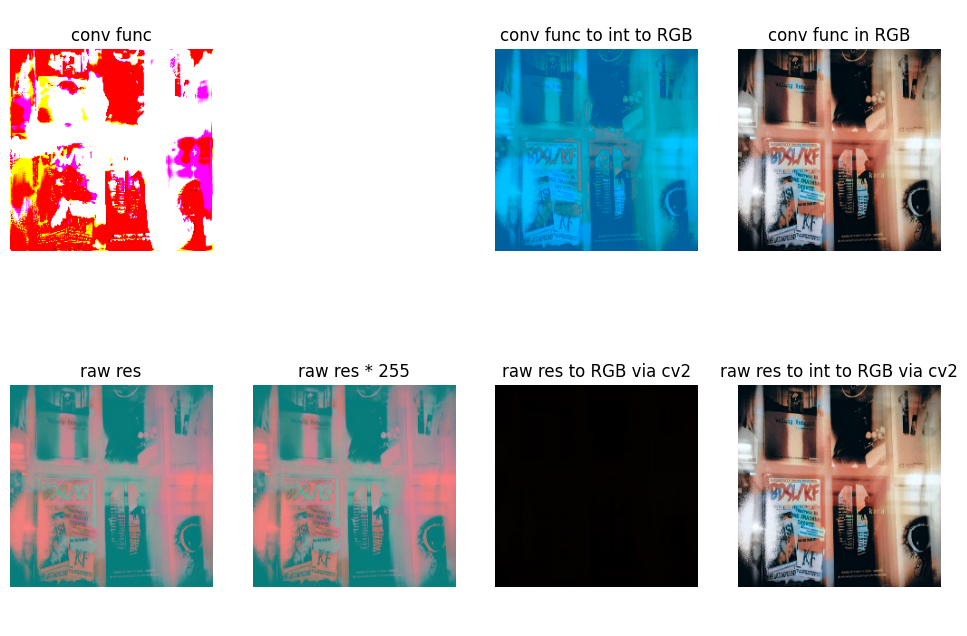

In [ ]:
plt.figure(figsize=(12, 8))
plt.axis('off')

rows = 2
cols = 4


plt.subplot(rows, cols, 1)
plt.title("conv func")
plt.axis('off')
plt.imshow(result_lab[0])  ## forgot to add `cmap="gray`?

plt.subplot(rows, cols, 3)
plt.title("conv func to int to RGB")
plt.axis('off')
plt.imshow(result_lab_in_rgb_int)

plt.subplot(rows, cols, 4)
plt.title("conv func in RGB")
plt.axis('off')
plt.imshow(result_lab_in_rgb)



plt.subplot(rows, cols, cols + 1)
plt.title("raw res")
plt.axis('off')
img = torch.cat([L_data, result], dim=1)[0].permute(1, 2, 0).cpu().numpy()
plt.imshow( img )

plt.subplot(rows, cols, cols + 2)
plt.title("raw res * 255")
plt.axis('off')
img_int = (img * 255).astype(np.uint8)
plt.imshow( img_int )

plt.subplot(rows, cols, cols + 3)
plt.title("raw res to RGB via cv2")
plt.axis('off')
img_rgb = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
plt.imshow( img_rgb )

plt.subplot(rows, cols, cols + 4)
plt.title("raw res to int to RGB via cv2")
plt.axis('off')
img_rgb = cv2.cvtColor(img_int, cv2.COLOR_LAB2RGB)
plt.imshow( img_rgb )

plt.show()

In [70]:
lab_temp = np.zeros((224, 224, 3), dtype=np.uint8) + np.array([80, 100, 100], dtype=np.uint8)
print(lab_temp.shape, lab_temp.dtype)
lab_temp[0, 0, :] # orange

(224, 224, 3) uint8


array([ 80, 100, 100], dtype=uint8)

R: 0 0
G: 87 87
B: 117 117


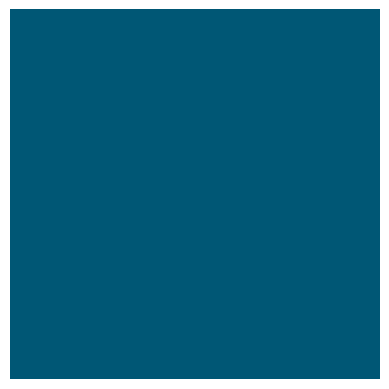

In [63]:
rgb_temp = cv2.cvtColor(lab_temp, cv2.COLOR_LAB2RGB)

print( "R:", rgb_temp[:, :, 0].min(), rgb_temp[:, :, 0].max() )
print( "G:", rgb_temp[:, :, 1].min(), rgb_temp[:, :, 1].max() )
print( "B:", rgb_temp[:, :, 2].min(), rgb_temp[:, :, 2].max() )

plt.axis("off")
plt.imshow(rgb_temp)
plt.show()

R: 255 255
G: 72 72
B: 0 0


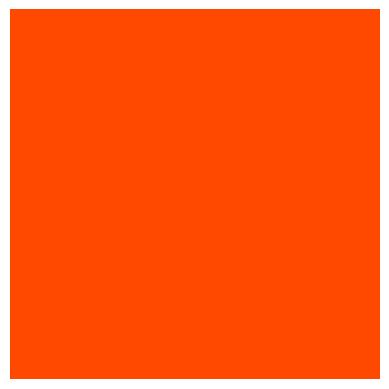

In [ ]:
## despite the common definition of Lab channels, it seems 
##  L channel in cv2 is assumed to be in [0,255] (instead of [0, 100])
##  a,b channels in cv2 are assumed to be in [0,255] (instead of [-128, 127])
lab_temp[..., 0] = (lab_temp[..., 0] / 100 * 255).astype(np.uint8)
lab_temp[..., 1:] = lab_temp[..., 1:] + 128

rgb_temp = cv2.cvtColor(lab_temp, cv2.COLOR_LAB2RGB)

print( "R:", rgb_temp[:, :, 0].min(), rgb_temp[:, :, 0].max() )
print( "G:", rgb_temp[:, :, 1].min(), rgb_temp[:, :, 1].max() )
print( "B:", rgb_temp[:, :, 2].min(), rgb_temp[:, :, 2].max() )

plt.axis("off")
plt.imshow(rgb_temp)
plt.show()

## !!! Right colour !!!

(224, 224, 3) float32
R: 1.0 1.0
G: 0.2834891 0.2834891
B: 0.0 0.0


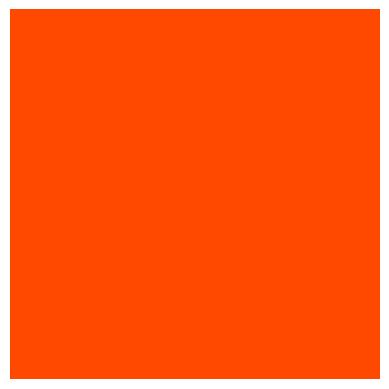

In [ ]:
## using Lab channels as L in [0., 100.]; a,b in [-128., 128.]
lab_temp = np.zeros((224, 224, 3), dtype=np.float32) + np.array([80., 100., 100.], dtype=np.float32)
print(lab_temp.shape, lab_temp.dtype)
lab_temp[0, 0, :] # orange


rgb_temp = cv2.cvtColor(lab_temp, cv2.COLOR_LAB2RGB)

print( "R:", rgb_temp[:, :, 0].min(), rgb_temp[:, :, 0].max() )
print( "G:", rgb_temp[:, :, 1].min(), rgb_temp[:, :, 1].max() )
print( "B:", rgb_temp[:, :, 2].min(), rgb_temp[:, :, 2].max() )

plt.axis("off")
plt.imshow(rgb_temp)
plt.show()

## !!! Right colour !!!

##### all files

In [16]:
L_ch = np.zeros(101, dtype=np.int64)
a_ch = np.zeros(256, dtype=np.int64)
b_ch = np.zeros(256, dtype=np.int64)
R_ch = np.zeros(256, dtype=np.int64)
G_ch = np.zeros(256, dtype=np.int64)
B_ch = np.zeros(256, dtype=np.int64)

tags = np.load(tags_path)
model = cwgan_gp.to(device)


for folder_num in tqdm(range(0, 100), colour="#10cbcb"):
    L_file = L_path / (str(folder_num).zfill(2) + ".npy")
    
    L_data = np.load(L_file)
    tags_data = tags[folder_num]


    dataset = ColorizDataset(L_data, tags_data,
                             stoi=words_to_inds, tag_num=tag_num,
                             transform=transform)
    loader = DataLoader(dataset=dataset, batch_size=batch_size,
                        shuffle=True)


    with torch.no_grad():
        for L_data, tags_data in loader:
            L_data = L_data.to(device)
            tags_data = tags_data.to(device)

            result = cwgan_gp(L_data, tags_data)


            ###   Lab   ###
            # batched to batched
            result = convert_to_Lab(L_data, result)  # [0, 1] -> [0, 100] | [-128, 128]
            result_int = result.astype(np.int8)
            
            # L
            inds, counts = np.unique(result_int[:, :, :, 0], return_counts=True)
            L_ch[inds] += counts
            
            # a
            inds, counts = np.unique(result_int[:, :, :, 1], return_counts=True)
            inds = inds.astype(np.uint8) + 128
            a_ch[inds] += counts

            # b
            inds, counts = np.unique(result_int[:, :, :, 2], return_counts=True)
            inds = inds.astype(np.uint8) + 128
            b_ch[inds] += counts


            ###   RGB   ###
            result = np.array([
                cv2.cvtColor(res, cv2.COLOR_LAB2RGB)
                for res in result
            ])
            result = (result * 255).astype(np.uint8)


            ## R
            inds, counts = np.unique(result[:, :, :, 0], return_counts=True)
            R_ch[inds] += counts

            ## G
            inds, counts = np.unique(result[:, :, :, 1], return_counts=True)
            G_ch[inds] += counts

            ## B
            inds, counts = np.unique(result[:, :, :, 2], return_counts=True)
            B_ch[inds] += counts
    
    

# to int after  -> 1:52 
# to int before -> 1:53

100%|██████████| 100/100 [4:16:56<00:00, 154.16s/it] 


In [17]:
print(
    f"total amount of pixels = {100 * 10_000 * 224 * 224:,}",
    "="*40,
    f"actual:",
    f"R = {int(R_ch.sum().item()):,}",
    f"G = {int(G_ch.sum().item()):,}",
    f"B = {int(B_ch.sum().item()):,}",
    f"L = {int(L_ch.sum().item()):,}",
    f"a = {int(a_ch.sum().item()):,}",
    f"b = {int(b_ch.sum().item()):,}",
    sep="\n"
)

total amount of pixels = 50,176,000,000
actual:
R = 50,176,000,000
G = 50,176,000,000
B = 50,176,000,000
L = 50,176,000,000
a = 50,176,000,000
b = 50,176,000,000


In [18]:
for k, v in words_to_inds.items():
    if not isinstance(k, str) or not isinstance(v, int):
        print(f"`{k}` - `{v}`")

#### graphs

In [19]:
labels = range(256)

ticks = [0, 25, 50, 100, 128, 150, 200, 250, 255]

##### lab

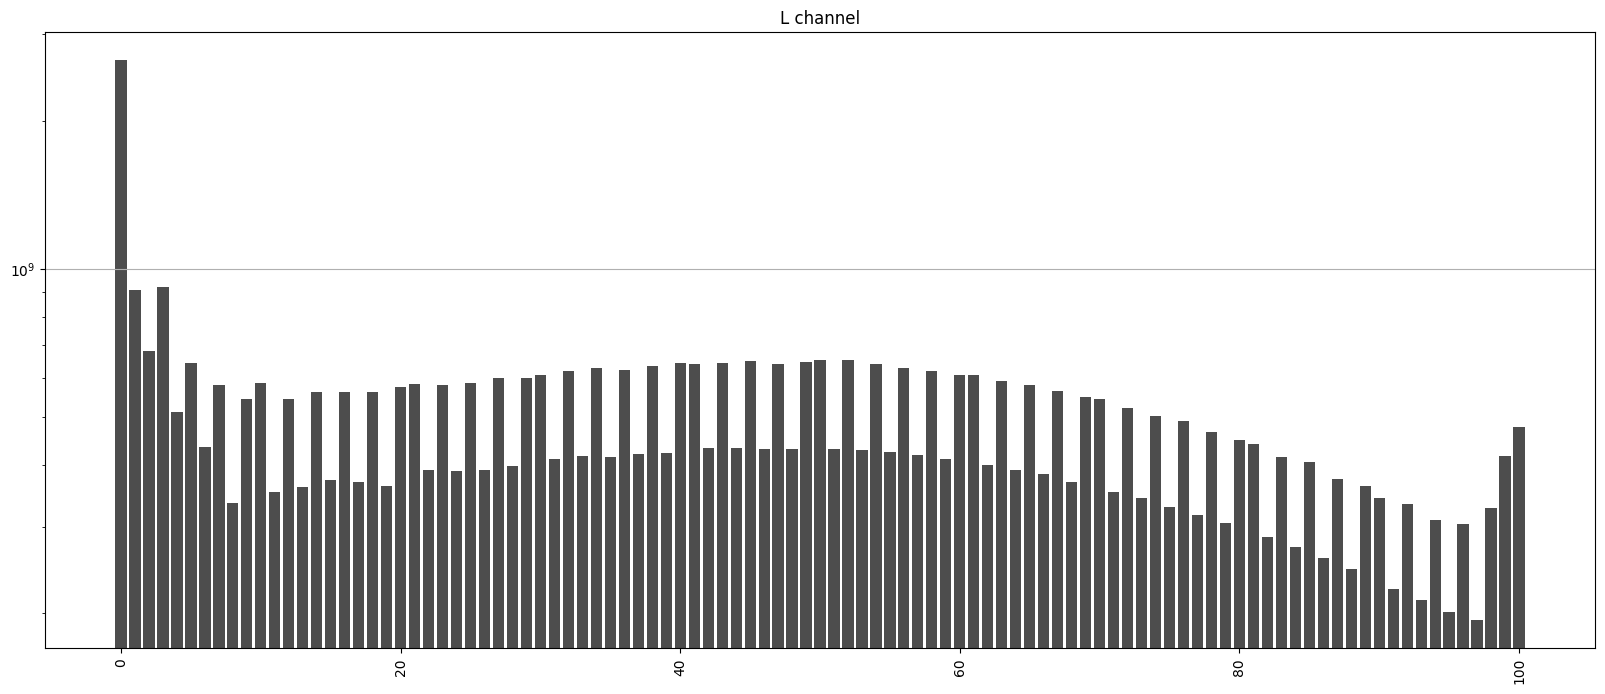

In [31]:
plt.figure(figsize=(20, 8))
plt.title("L channel")

plt.bar(range(101), L_ch, color="#4d4d4d")
plt.xticks(rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

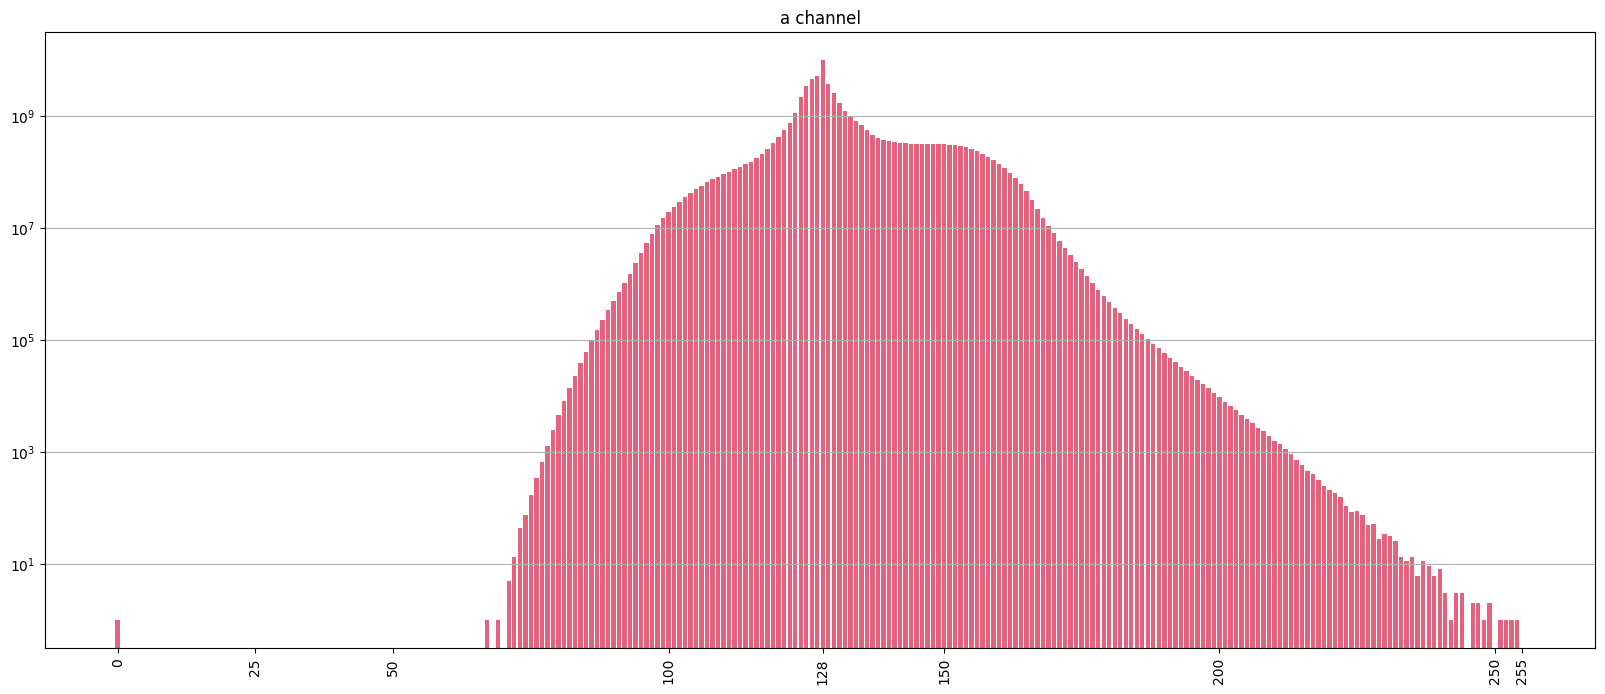

In [21]:
plt.figure(figsize=(20, 8))
plt.title("a channel")

plt.bar(labels, a_ch, color="#e4627e")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

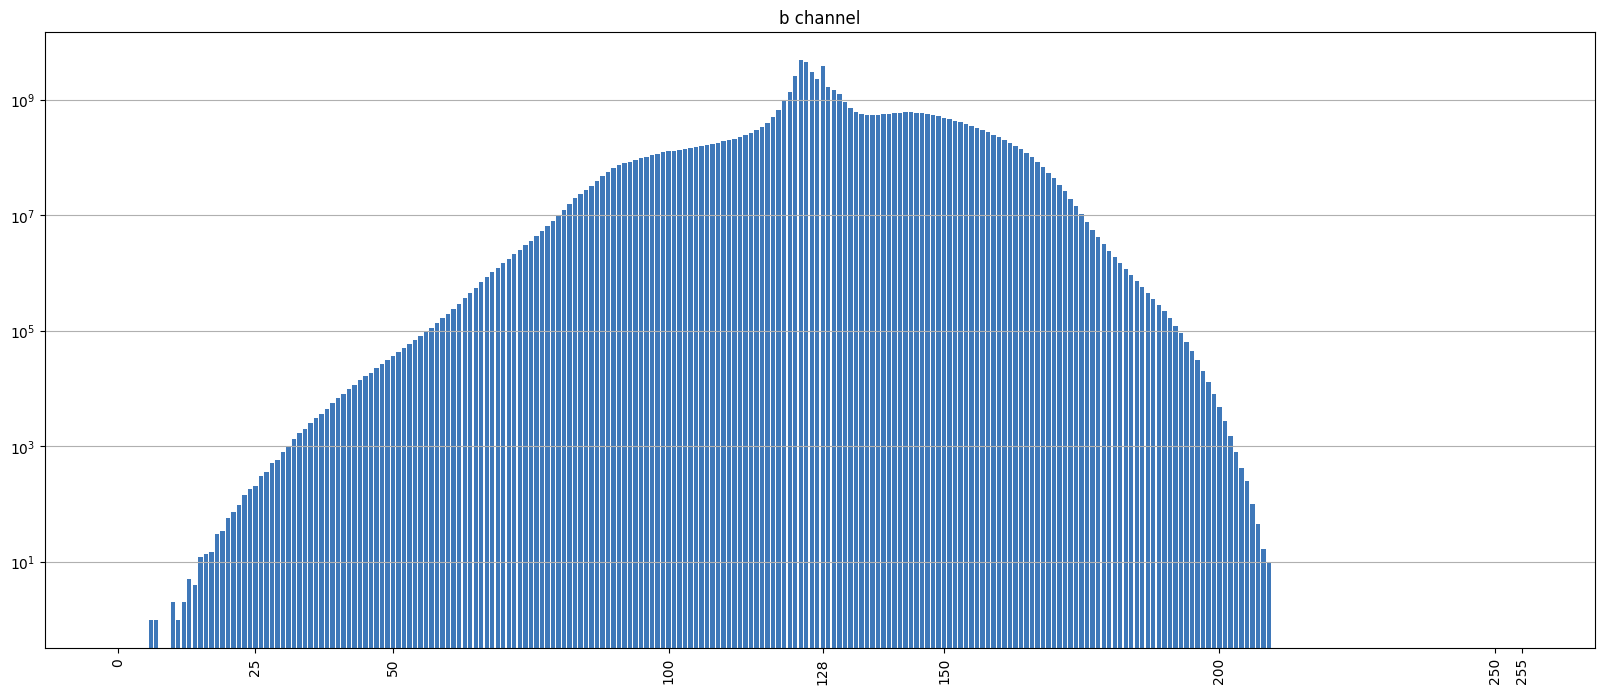

In [22]:
plt.figure(figsize=(20, 8))
plt.title("b channel")

plt.bar(labels, b_ch, color="#3f78b9")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

##### rgb

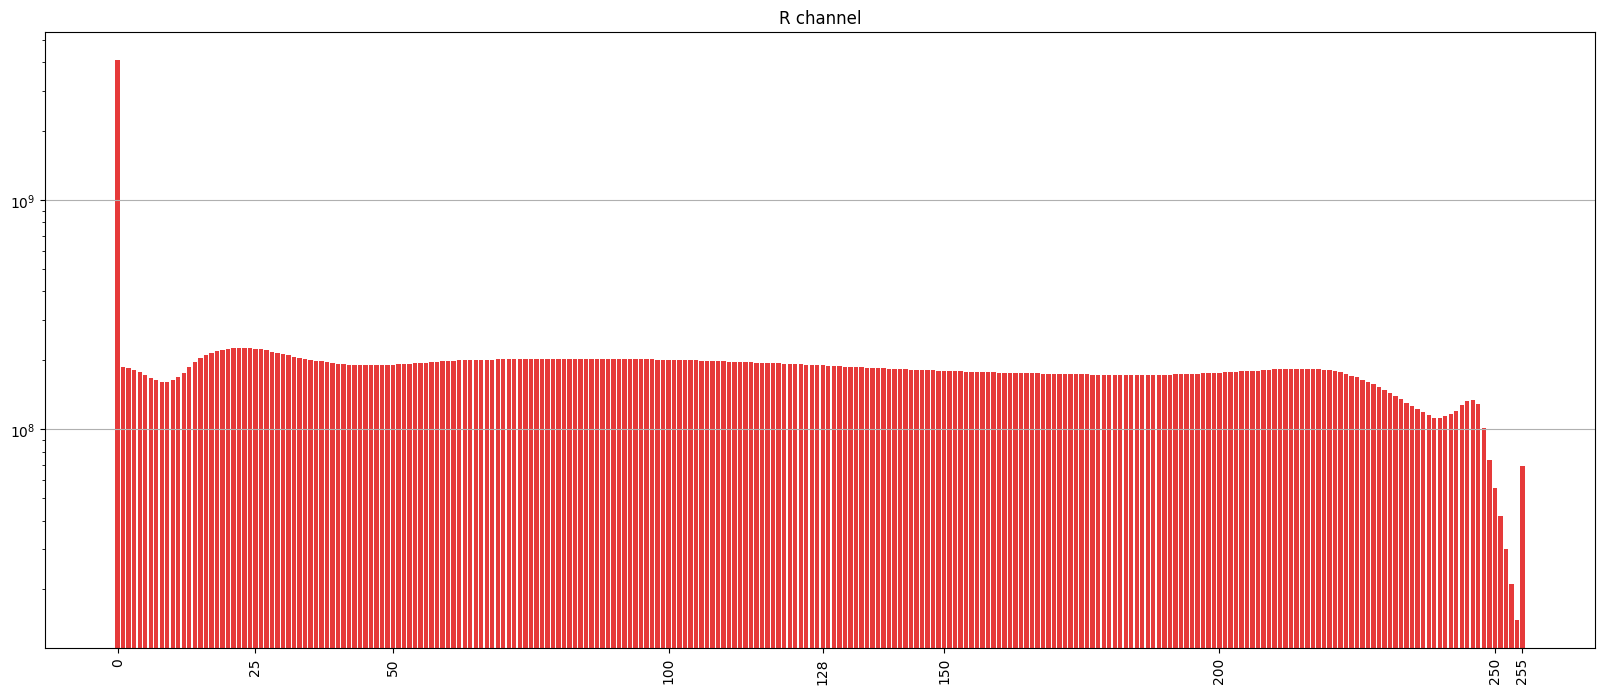

In [23]:
plt.figure(figsize=(20, 8))
plt.title("R channel")

plt.bar(labels, R_ch, color="#e63a3a")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

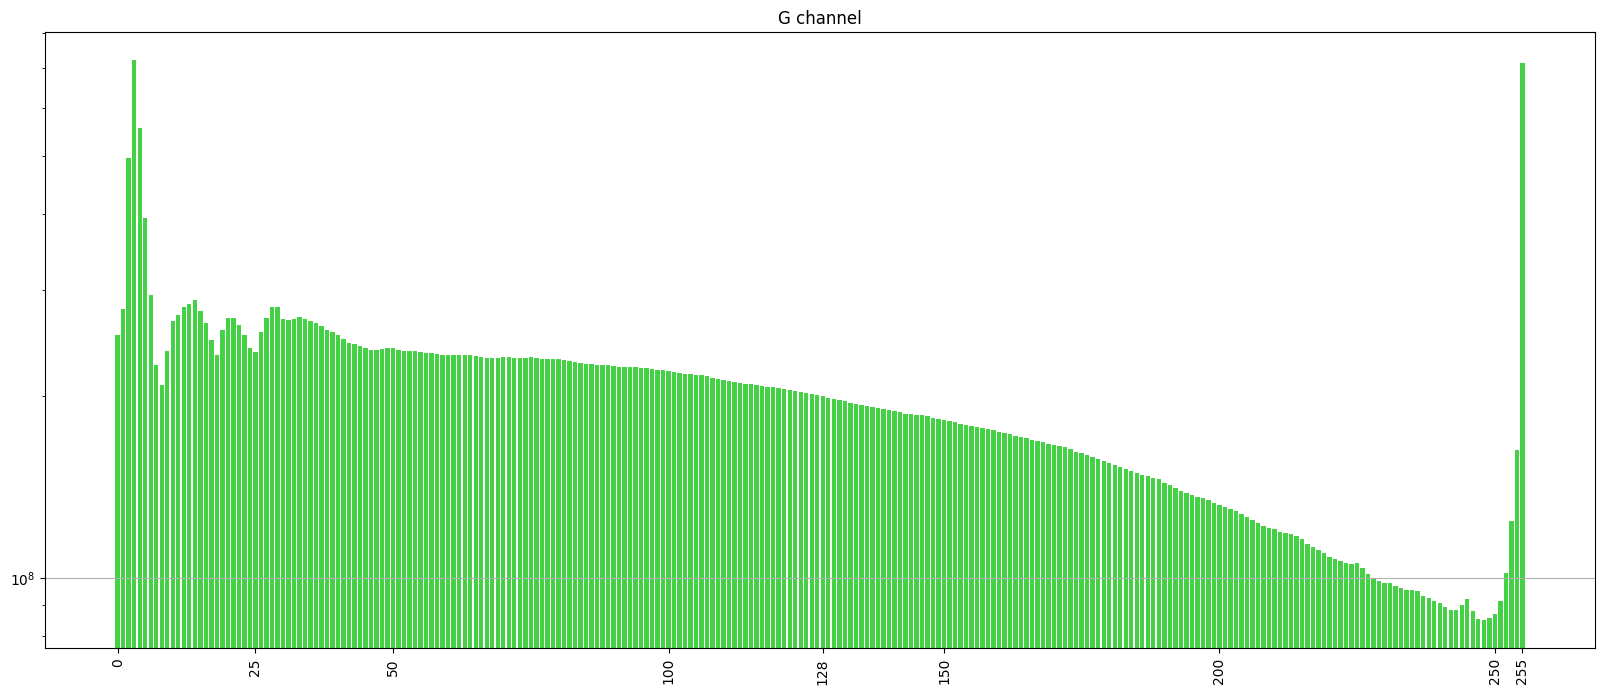

In [24]:
plt.figure(figsize=(20, 8))
plt.title("G channel")

plt.bar(labels, G_ch, color="#45d145")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

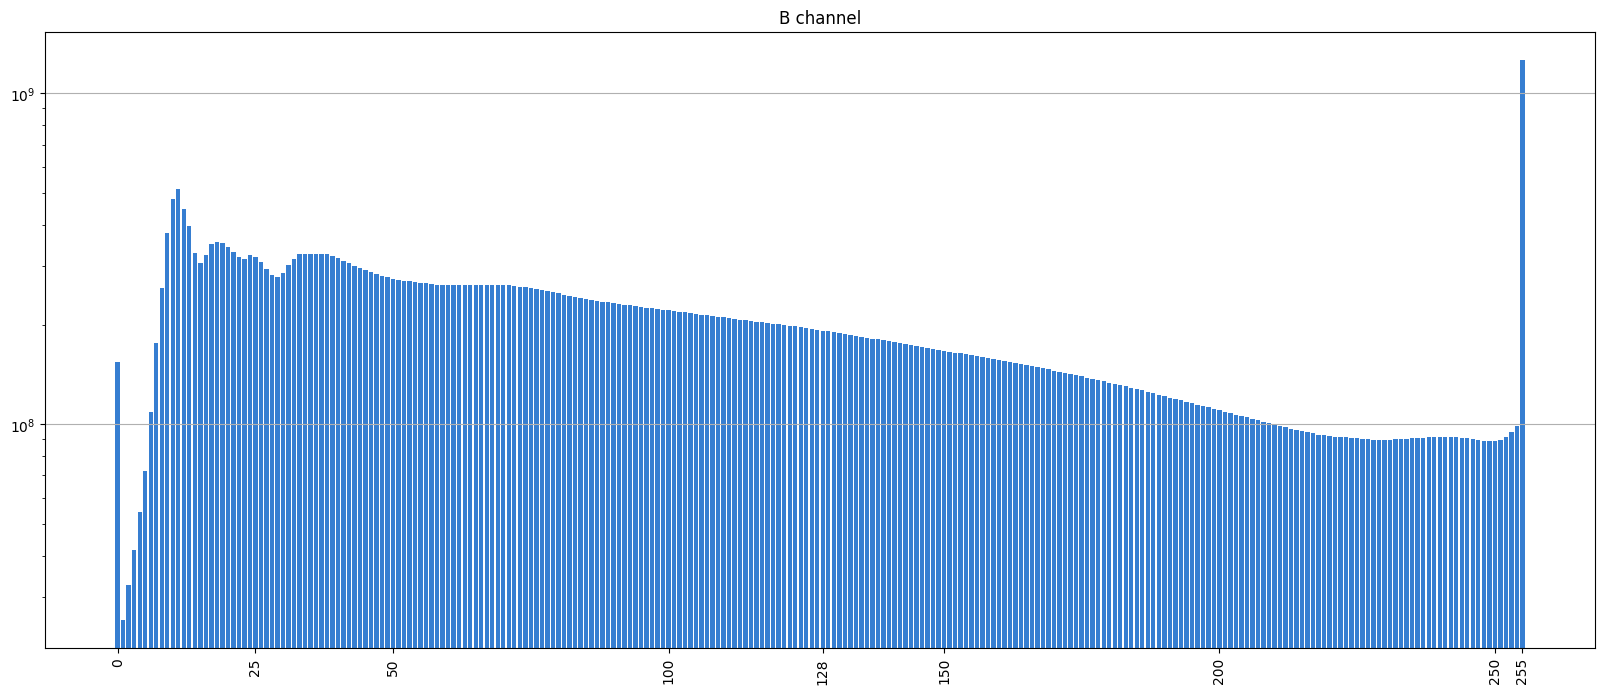

In [25]:
plt.figure(figsize=(20, 8))
plt.title("B channel")

plt.bar(labels, B_ch, color="#367ed1")
plt.xticks(ticks=ticks, rotation='vertical')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

#### save

In [ ]:
version = 0
epoch = 16

folder = f"statistics/training_history/{version}"

In [ ]:
np.save(data_folder / folder / f"R_channels_gened_{epoch}.npy", R_ch)
np.save(data_folder / folder / f"G_channels_gened_{epoch}.npy", G_ch)
np.save(data_folder / folder / f"B_channels_gened_{epoch}.npy", B_ch)

In [ ]:
np.save(data_folder / folder / f"L_channels_gened_{epoch}.npy", L_ch)
np.save(data_folder / folder / f"a_channels_gened_{epoch}.npy", a_ch)
np.save(data_folder / folder / f"b_channels_gened_{epoch}.npy", b_ch)